# EGGS Data

## Import packages

In [65]:
import os 
import datetime
import shapefile as shp
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# from matplotlib.colors import ListedColormap
# from mpl_toolkits.axes_grid1 import make_axes_locatable

## Import Data

### SD6KS Surrounding Fields Shapefile as GeoDataFrame

In [3]:
# Create filepath for shapefile
# Always run the filepath first for each different file you read in since the files are in different folders
fields_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Property Lines"

# Change working directory to the filepath
os.chdir(fields_fp)

# Read in file as a geodataframe using GeoPandas
fields = gpd.read_file('Fields_Around_SD6KS.shp')

Get bounding coordinates using shapefile package

In [4]:
fields_coords = shp.Reader("Fields_Around_SD6KS.shp")
fields_coords.bbox

[-423875.3471000008, 1803101.1964999996, -362791.8465999998, 1854546.488500001]

Visualize shapefile

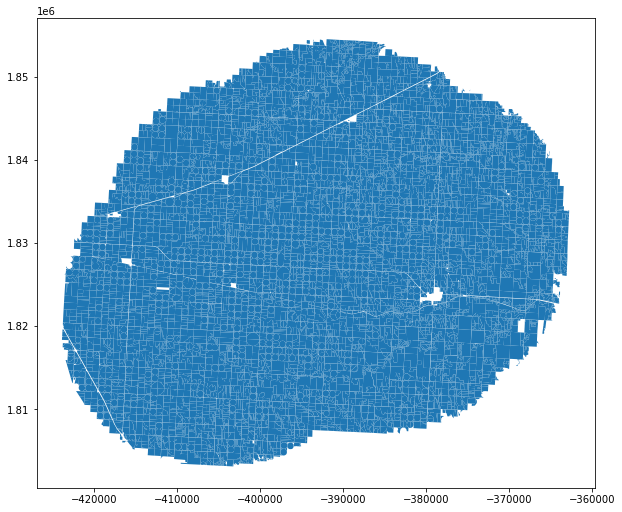

In [5]:
fig, ax = plt.subplots(figsize = (10,10))
fields.plot(ax=ax)
plt.show()

### SD6KS Boundary Shapefile

In [6]:
boundary_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(boundary_fp)
boundary = gpd.read_file('Boundary_SD6KS_BWilson_20220616.shp')

In [7]:
boundary_coords = shp.Reader("Boundary_SD6KS_BWilson_20220616.shp")
boundary_coords.bbox

[346774.9221245285, 4352264.910569741, 375914.3972205508, 4371371.047506346]

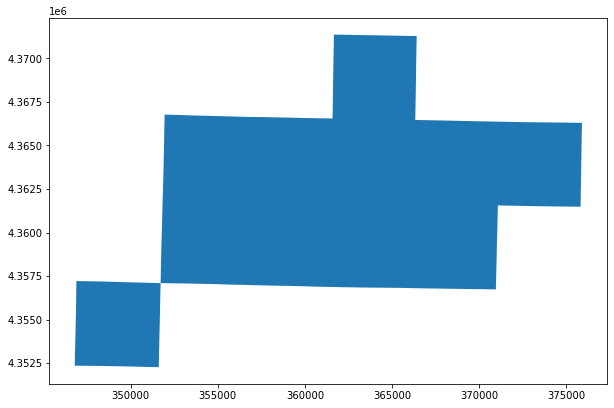

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
boundary.plot(ax=ax)
plt.show()

### SD6KS Buffer Shapefile

In [9]:
buffer_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(buffer_fp)
buffer = gpd.read_file('BoundaryBuffer_SD6KS_BWilson_20220616.shp')

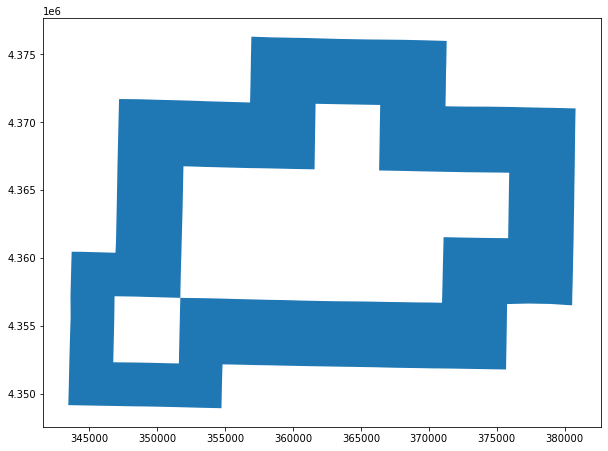

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
buffer.plot(ax=ax)
plt.show()

### Overlaying Shapefiles

In [11]:
# Change boundary and buffer to same CRS as fields so they can be layered on top
boundary = boundary.to_crs(fields.crs)
buffer = buffer.to_crs(fields.crs)

<AxesSubplot:>

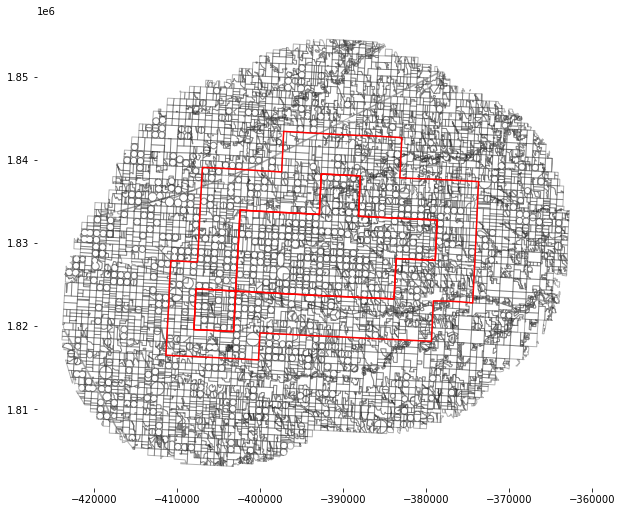

In [12]:
fig, ax = plt.subplots(figsize = (10,10))

# Set the base as the fields shapefile
base = fields.plot(ax=ax, color='white', edgecolor='k', alpha=0.3)
ax.spines['top'].set_visible(False) # remove border around plot
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Plot the boundary and buffer on top of fields, setting the ax = base
# Set color of the line to black
boundary.boundary.plot(ax=base, color='red')
buffer.boundary.plot(ax=base, color='red')

### Clipping to LEMA

In [13]:
lema = gpd.clip(fields, boundary)

### OpenET Data (mm, annually by field)

In [182]:
# Create a filepath for OpenET data and change working directory
openET_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\OpenET\\"
os.chdir(openET_fp)

In [183]:
# Import ensemble file from OpenET
ensemble = pd.read_csv('ET_monthly_ensemble_FieldsAroundSD6KS_20220708.csv')

# Import DisALEXI file from OpenET
disalexi = pd.read_csv('ET_monthly_disalexi_FieldsAroundSD6KS_20220708.csv')

# Import eeMetric file from OpenET
eemetric = pd.read_csv('ET_monthly_eemetric_FieldsAroundSD6KS_20220708.csv')

# Import geeSEBAL file from OpenET
geesebal = pd.read_csv('ET_monthly_geesebal_FieldsAroundSD6KS_20220708.csv')

# Import PT-JPL file from OpenET
ptjpl = pd.read_csv('ET_monthly_ptjpl_FieldsAroundSD6KS_20220708.csv')

# Import SIMS file from OpenET
sims = pd.read_csv('ET_monthly_sims_FieldsAroundSD6KS_20220708.csv')

# Import SSEBop file from OpenET
ssebop = pd.read_csv('ET_monthly_ssebop_FieldsAroundSD6KS_20220708.csv')

In [184]:
# Create lists for the following for loop
et = [ensemble, disalexi, eemetric, geesebal, ptjpl, sims, ssebop]
lab = ['annual_ensemble', 'annual_disalexi', 'annual_eemetric', 'annual_geesebal', 'annual_ptjpl', 'annual_sims', 'annual_ssebop']

In [185]:
# Create a dictionary to store dataframes in
annual_et = {}

i = 0 # Used to set first index for lab

# Use a for loop to wrangle data from monthly into annual data (NOTE: WILL TAKE ~10-11 MINS TO RUN)
for x in et:
    x.drop('acres', inplace = True, axis = 1) # drop irrelevant columns
    merge_x = fields.merge(x, on = 'UID', how = 'left') # merge dataframes and shapefile together
    x_fields = gpd.GeoDataFrame(merge_x) # turn into geodataframe
    x_fields.time = pd.to_datetime(x_fields.time).dt.strftime('%Y') # change time column to datetime
    annual_et[lab[i]] = x_fields.dissolve(by = ['UID', 'time'], aggfunc = 'sum') # assign to dictionary, group by UID and time and sum the rest of the columns
    # annual_et[lab[i]].drop('area', inplace = True, axis = 1) # drop irrelevant columns
    annual_et[lab[i]].reset_index(inplace=True) # ungroup from index format
    i += 1 # since index for lab was set to 0, this adds 1 to each iteration of for loop

In [186]:
# Change the names so that they are easier to call
annual_ensemble = annual_et['annual_ensemble']
annual_disalexi = annual_et['annual_disalexi']
annual_eemetric = annual_et['annual_eemetric']
annual_geesebal = annual_et['annual_geesebal']
annual_ptjpl = annual_et['annual_ptjpl']
annual_ssebop = annual_et['annual_ssebop']
annual_sims = annual_et['annual_sims']

### gridMET Data (mm, annually by field)

In [19]:
# Create gridMET filepath and change working directory
gridmet_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\gridMET\\"
os.chdir(gridmet_fp)

# Read in gridmet file
gridmet = pd.read_csv('DailyMet_FieldsAroundSD6KS_2016-2021_20220802.csv')

In [20]:
# Change date_ymd column to datetime format
gridmet["date_ymd"] = pd.to_datetime(gridmet["date_ymd"], format='%Y%m%d')
gridmet.drop(['eto', 'etr'], inplace = True, axis = 1) # drop irrelevant columns
# Simplify date column to just years
gridmet.date_ymd = pd.to_datetime(gridmet.date_ymd).dt.strftime('%Y')

In [21]:
# Create annual precipitation dataframe
annual_gridmet = gridmet.groupby(['UID','date_ymd'])['pr'].sum().reset_index()
# Merge with shapefile
annual_gridmet = gpd.GeoDataFrame(fields.merge(annual_gridmet, on = 'UID', how = 'left'))
annual_gridmet.drop('area', inplace = True, axis = 1) # drop irrelevant columns
# Rename column to time instead of date_ymd
annual_gridmet = annual_gridmet.rename({'date_ymd': 'time'}, axis=1)

#### Adjusting gridMET Data into Precipitation Data by Year

In [22]:
# Pivot dataset so that the columns represent the years and the values are the precip
gridmet_pivot = gpd.GeoDataFrame(annual_gridmet.pivot(index = 'UID', columns = 'time', values = 'pr'))
gridmet_pivot.reset_index(inplace = True) # reset the index
gridmet_pivot.columns = gridmet_pivot.columns.astype(str) # change column types to strings
gridmet_pivot = gridmet_pivot[['UID', '2016', '2017', '2018', '2019', '2020', '2021']] # Select relevant columns

In [23]:
# Check for NaN values and create new dataframe that only has NaN values
gridmet_null = gridmet_pivot[gridmet_pivot.isna().any(axis=1)] # there are 20 rows that are NaN
# Merge with fields shapefile
gridmet_null = fields.merge(gridmet_null, on = 'UID')
# Select relevant columns and just make sure it's a gpd
gridmet_null = gpd.GeoDataFrame(gridmet_null[['UID', 'geometry']])

In [24]:
# Create new dataframe by copying old one
grid_null = gridmet_null.copy()
# Create centroid column to find the centroid of each polygon so that the geometry is in point form
grid_null['centroid'] = grid_null.to_crs('epsg:4326').centroid.to_crs(grid_null.crs)
# Find the longitude and latitude of each polygon
grid_null['lon'] = grid_null['geometry'].to_crs('epsg:4326').centroid.x
grid_null['lat'] = grid_null['geometry'].to_crs('epsg:4326').centroid.y
# Make sure it's all in the same CRS of EPSG 4326
grid_null = grid_null.to_crs(epsg=4326)
# Select relevant columns
grid_null = grid_null[['UID', 'centroid', 'lon', 'lat']]
# Rename the centroid column to geometry
grid_null = grid_null.rename({'UID':'UID_null','centroid': 'geometry'}, axis=1)

C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\4215927630.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['centroid'] = grid_null.to_crs('epsg:4326').centroid.to_crs(grid_null.crs)
C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\4215927630.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['lon'] = grid_null['geometry'].to_crs('epsg:4326').centroid.x
C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\4215927630.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['lat'] = grid_null['geometry'].to_crs('epsg:4326').centroid.y


In [25]:
# Set crs to EPSG 4326
crs = {'init': 'epsg:4326'}
# Set geometry so that the points are equal to the lat and long
from shapely import geometry
geometry = [geometry.Point(xy) for xy in zip(grid_null['lon'], grid_null['lat'])]
# Once again just make sure everything is in the correct format
grid_null = gpd.GeoDataFrame(grid_null, crs=crs, geometry=geometry)

C:\Users\ashle\anaconda3\envs\eggs\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [26]:
# Create new dataframe made up of fields that don't contain NaN
gridmet_val = gridmet_pivot.dropna()
# Merge with fields geodataframe
gridmet_val = fields.merge(gridmet_val, on = 'UID') # merge with shapefile
gridmet_val = gpd.GeoDataFrame(gridmet_val) # merge with shapefile
gridmet_val = gpd.GeoDataFrame(gridmet_val[['UID', 'geometry']]) # select relevant columns
# Create new dataframe by copying old one
grid_val = gridmet_val.copy()
# Create centroid column to find the centroid of each polygon so that the geometry is in point form
grid_val['centroid'] = grid_val.to_crs('epsg:4326').centroid.to_crs(grid_val.crs)
# Find the longitude and latitude of each polygon
grid_val['lon'] = grid_val['geometry'].to_crs('epsg:4326').centroid.x
grid_val['lat'] = grid_val['geometry'].to_crs('epsg:4326').centroid.y
# Make sure it's all in the same CRS of EPSG 4326
grid_val = grid_val.to_crs(epsg=4326)
# Select relevant columns
grid_val = grid_val[['UID', 'centroid', 'lon', 'lat']]
# Rename the centroid column to geometry
grid_val = grid_val.rename({'centroid': 'geometry'}, axis=1)

C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\1756000616.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['centroid'] = grid_val.to_crs('epsg:4326').centroid.to_crs(grid_val.crs)
C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\1756000616.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['lon'] = grid_val['geometry'].to_crs('epsg:4326').centroid.x
C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\1756000616.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['lat'] = grid_val['geometry'].to_crs('epsg:4326').centroid.y


In [27]:
# Set crs to EPSG 4326
crs = {'init': 'epsg:4326'}
# Set geometry so that the points are equal to the lat and long
from shapely import geometry
geom = [geometry.Point(xy) for xy in zip(grid_val['lon'], grid_val['lat'])]
# Once again just make sure everything is in the correct format
grid_val = gpd.GeoDataFrame(grid_val, crs=crs, geometry=geom)

C:\Users\ashle\anaconda3\envs\eggs\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [28]:
# Nearest neighbor script and helper functions using haversine distance formula
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [29]:
# Apply helper function to find nearest neighbor for each null data point
nearest_field = nearest_neighbor(grid_null, grid_val, return_dist=True)
# Make sure UID_null type is float
grid_null['UID_null'] = grid_null['UID_null'].astype('float')

In [30]:
# Join grid_null and nearest_field together since the UID in nearest_field represents the UID_null in grid_null
join_uid = pd.DataFrame(pd.concat([grid_null['UID_null'], nearest_field['UID']],
                                  axis=1, 
                                  keys=['UID_null', 'UID']))

In [196]:
# Create new dataframe made up of fields that don't contain NaN again
update_val = gridmet_pivot.dropna()
# Merge with fields geodataframe
update_val = gpd.GeoDataFrame(fields.merge(update_val, on = 'UID'))
# Drop irrelevant columns
# update_val.drop('area', inplace=True, axis=1)

In [197]:
# Merge update_val with join_uid to create df that has precip values
null_merge = join_uid.merge(update_val, on = 'UID')
# Drop UID column so that UID_null fields match with precip values
null_merge = null_merge[['UID_null', '2016', '2017', '2018', '2019', '2020', '2021']]

In [198]:
# Create precip df by setting the indices to UID so that they merge correctly
precip = gridmet_pivot.set_index('UID')
precip = precip.fillna(null_merge.set_index('UID_null')) # merge with null_merge df to use adjusted values
precip.reset_index(inplace=True) # reset index
# Check for NaN values
# nullcheck = precip[precip.isna().any(axis=1)] # there are no rows with NaN anymore

In [199]:
precip = gpd.GeoDataFrame(fields.merge(precip, on = 'UID', how = 'left')) # merge with shapefile
# precip.drop('area', inplace=True, axis=1) # drop irrelevant columns

### Irrigation Status (%, annually by field)

In [35]:
# Create irrigation status filepath and change working directory
aim_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Irrigation Status"
os.chdir(aim_fp)

# Read in AIM file and filter out years less than 2016
aim = pd.read_csv('FieldsAttributes_FieldsAroundSD6KS_Irrigation_AnnualAIM.csv')
aim.UID = aim.UID.astype('float')

In [36]:
# Pivot dataset so that the columns represent the years and the values are the precip
aim_adjust = aim[aim['Year'] > 2015]
aim_pivot = aim_adjust.pivot(index = 'UID', columns = 'Year', values = 'IrrigatedPrc')
aim_pivot.reset_index(inplace = True) # reset the index
aim_pivot.columns = aim_pivot.columns.astype(str) # set column names as strings

In [37]:
# Any field 0.5 and above is considered irrigated, anything below is rainfed

# 2016 Irrigated & Rainfed Fields
aim_irr_2016 = aim_pivot[aim_pivot['2016'] >= 0.5]
aim_irr_2016 = aim_irr_2016[['UID']]
aim_rain_2016 = aim_pivot[aim_pivot['2016'] < 0.5]
aim_rain_2016 = aim_rain_2016[['UID']]

# 2017 Irrigated & Rainfed Fields
aim_irr_2017 = aim_pivot[aim_pivot['2017'] >= 0.5]
aim_irr_2017 = aim_irr_2017[['UID']]
aim_rain_2017 = aim_pivot[aim_pivot['2017'] < 0.5]
aim_rain_2017 = aim_rain_2017[['UID']]

# 2018 Irrigated & Rainfed Fields
aim_irr_2018 = aim_pivot[aim_pivot['2018'] >= 0.5]
aim_irr_2018 = aim_irr_2018[['UID']]
aim_rain_2018 = aim_pivot[aim_pivot['2018'] < 0.5]
aim_rain_2018 = aim_rain_2018[['UID']]

# 2019 Irrigated & Rainfed Fields
aim_irr_2019 = aim_pivot[aim_pivot['2019'] >= 0.5]
aim_irr_2019 = aim_irr_2019[['UID']]
aim_rain_2019 = aim_pivot[aim_pivot['2019'] < 0.5]
aim_rain_2019 = aim_rain_2019[['UID']]

# 2020 Irrigated & Rainfed Fields
aim_irr_2020 = aim_pivot[aim_pivot['2020'] >= 0.5]
aim_irr_2020 = aim_irr_2020[['UID']]
aim_rain_2020 = aim_pivot[aim_pivot['2020'] < 0.5]
aim_rain_2020 = aim_rain_2020[['UID']]

### Annual CDL (CropCode, pctcov, annually by field)

In [38]:
# Create annual CDL filepath
cdl_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Land Use-Land Cover"
os.chdir(cdl_fp)

In [39]:
cdl = pd.read_csv('FieldsAttributesAroundSD6KS_LandCover_AnnualCDL.csv')
cdl.UID = cdl.UID.astype('float') # set UID values as floats

### AIM and CDL Data Combined

In [40]:
aim_cdl = aim.merge(cdl, on=['UID','Year'])

### Soil Data (by field)

In [41]:
# Create soil data filepath
soil_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Soils"
os.chdir(soil_fp)

In [42]:
soil = pd.read_csv('Soil_FieldsAroundSD6KS_POLARIS_AGrinstead_20220706.csv', index_col = 0)

In [43]:
# Merge dataframe with shapefile dataframe so that it can be plotted on a map
merge_soil = fields.merge(soil, on='UID', how='left')
soil_fields = gpd.GeoDataFrame(merge_soil)

## Graphs & New Datasets

### Annual Mean ET

In [187]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'area',
           'ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['area'],
     annual_ensemble['et_mean'],
     annual_disalexi['et_mean'],
     annual_eemetric['et_mean'],
     annual_geesebal['et_mean'],
     annual_ptjpl['et_mean'],
     annual_ssebop['et_mean'],
     annual_sims['et_mean']],
axis=1,
keys=column_names)
)

In [188]:
# Create a list for the following for loop 
col = ['ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_mean_et = dict()

for x in col:
    annual_mean_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame['UID'],
     ame['time'],
     ame['geometry'],
     ame['area'],
     ame[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry',
           'area', 
           str(x)])
)

In [189]:
# Create a dictionary using a for loop to merge dataframe
mean_et = dict()

for i in col:
    df = gpd.GeoDataFrame(annual_mean_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df, on = 'UID', how = 'left') # merge with shapefile
    mean_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    # mean_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [190]:
# Create variables easier to call
mean_ensemble = mean_et['ensemble_et_mean']
mean_disalexi = mean_et['disalexi_et_mean']
mean_eemetric = mean_et['eemetric_et_mean']
mean_geesebal = mean_et['geesebal_et_mean']
mean_ptjpl = mean_et['ptjpl_et_mean']
mean_ssebop = mean_et['ssebop_et_mean']
mean_sims = mean_et['sims_et_mean']

In [191]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
mean_et_list = [mean_ensemble, mean_disalexi, mean_eemetric, mean_geesebal, mean_ptjpl, mean_ssebop, mean_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

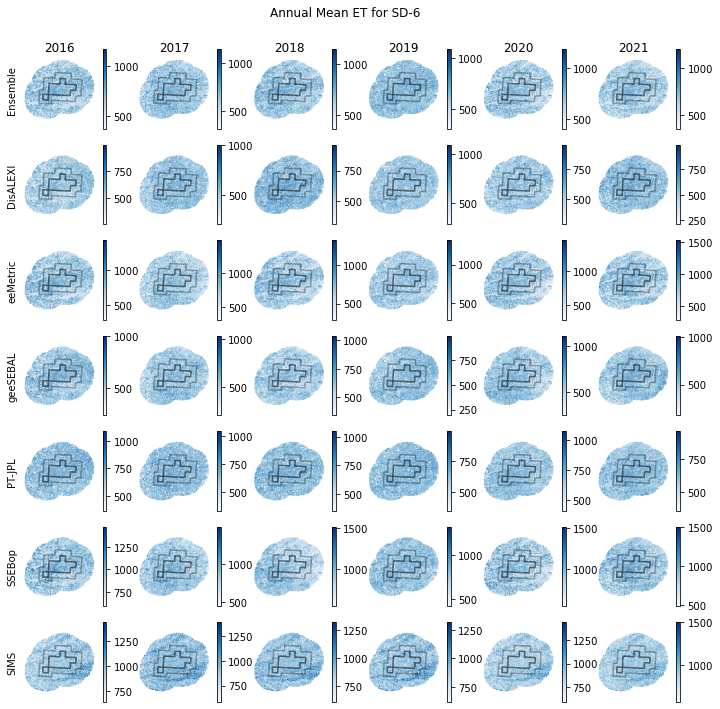

In [49]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Mean ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = mean_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('AnnualMeanETSD6.png', dpi=500)
plt.show()

### Annual Min ET 

In [50]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame1 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_min'],
     annual_disalexi['et_min'],
     annual_eemetric['et_min'],
     annual_geesebal['et_min'],
     annual_ptjpl['et_min'],
     annual_ssebop['et_min'],
     annual_sims['et_min']],
axis=1,
keys=column_names)
)

In [51]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_min_et = dict()

for x in col:
    annual_min_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame1['UID'],
     ame1['time'],
     ame1['geometry'],
     ame1[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [52]:
# Create a dictionary using a for loop to merge dataframe
min_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_min_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    min_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    min_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [53]:
# Create variables easier to call
min_ensemble = min_et['ensemble_et_min']
min_disalexi = min_et['disalexi_et_min']
min_eemetric = min_et['eemetric_et_min']
min_geesebal = min_et['geesebal_et_min']
min_ptjpl = min_et['ptjpl_et_min']
min_ssebop = min_et['ssebop_et_min']
min_sims = min_et['sims_et_min']

In [54]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
min_et_list = [min_ensemble, min_disalexi, min_eemetric, min_geesebal, min_ptjpl, min_ssebop, min_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

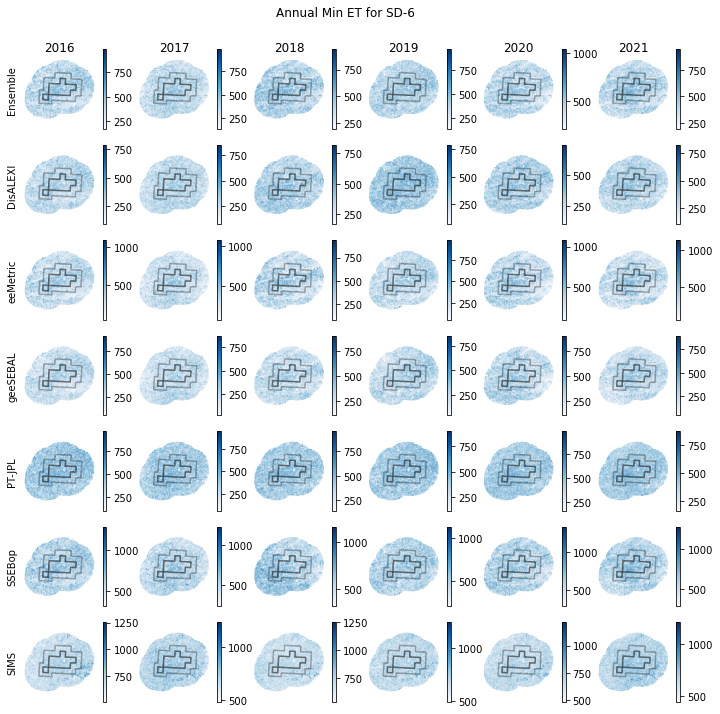

In [55]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Min ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = min_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('AnnualMinETSD6.png', dpi=500)
plt.show()

### Annual Max ET

In [56]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame2 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_max'],
     annual_disalexi['et_max'],
     annual_eemetric['et_max'],
     annual_geesebal['et_max'],
     annual_ptjpl['et_max'],
     annual_ssebop['et_max'],
     annual_sims['et_max']],
axis=1,
keys=column_names)
)

In [57]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_max_et = dict()

for x in col:
    annual_max_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame2['UID'],
     ame2['time'],
     ame2['geometry'],
     ame2[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [58]:
# Create a dictionary using a for loop to merge dataframe
max_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_max_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    max_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    max_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [59]:
# Create variables easier to call
max_ensemble = max_et['ensemble_et_max']
max_disalexi = max_et['disalexi_et_max']
max_eemetric = max_et['eemetric_et_max']
max_geesebal = max_et['geesebal_et_max']
max_ptjpl = max_et['ptjpl_et_max']
max_ssebop = max_et['ssebop_et_max']
max_sims = max_et['sims_et_max']

In [60]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
max_et_list = [max_ensemble, max_disalexi, max_eemetric, max_geesebal, max_ptjpl, max_ssebop, max_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

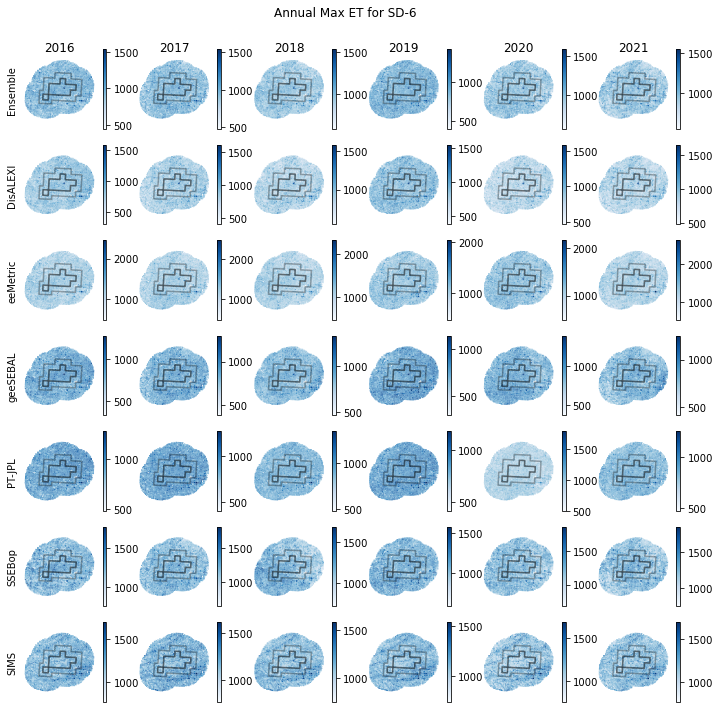

In [61]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Max ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = max_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('AnnualMaxETSD6.png', dpi=500)
plt.show()

### Annual % Irrigated Fields for SD-6

In [62]:
aim_years = gpd.GeoDataFrame(fields.merge(aim_pivot, on = 'UID', how = 'left'))
aim_years.drop('area', inplace=True, axis=1)

In [63]:
# Create list that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020']

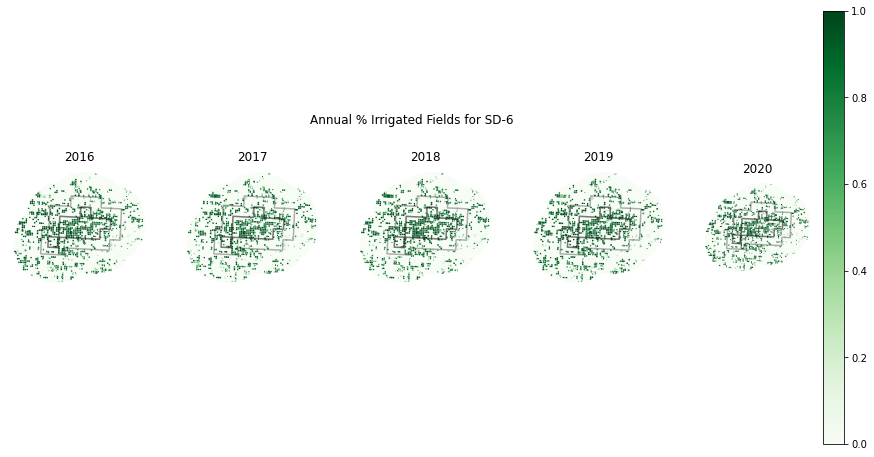

In [66]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 8))
fig.suptitle('Annual % Irrigated Fields for SD-6', y=0.70)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 1
cols = 5
for r in range(rows):
    for c in range(cols):
        y = years[c]
        aim_years.plot(aim_years[y], ax=axs[c], cmap='Greens')
        boundary.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        axs[c].patch.set_facecolor('white')
        axs[c].set_xticks([]) # remove tick marks 
        axs[c].set_xticklabels([]) # remove tick mark labels
        axs[c].set_yticks([])
        axs[c].set_yticklabels([])
        axs[c].spines['top'].set_visible(False) # remove border around plot
        axs[c].spines['right'].set_visible(False)
        axs[c].spines['bottom'].set_visible(False)
        axs[c].spines['left'].set_visible(False)
        axs[c].set_title(y) # set year titles for each column

fig.colorbar(cm.ScalarMappable(cmap='Greens'), ax=axs[c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('AnnualIrrigatedFieldsSD6.png', dpi=500)
plt.show()

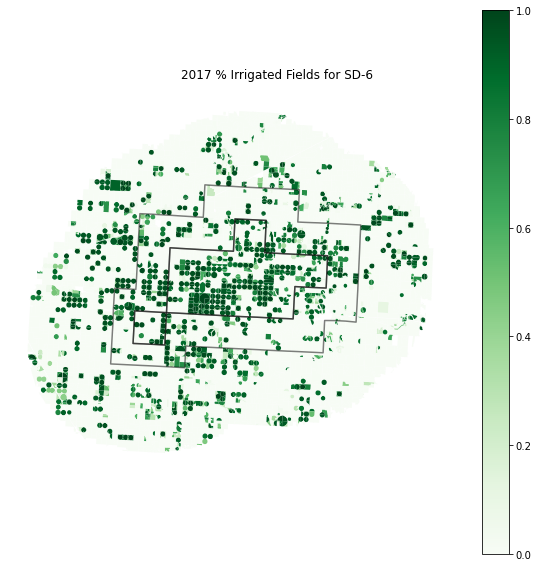

In [67]:
fig, axs = plt.subplots(figsize=(10,10))
fig.suptitle('2017 % Irrigated Fields for SD-6', y=0.80)
fig.patch.set_facecolor('white')

aim_years.plot(aim_years['2017'], ax=axs, legend=True, cmap='Greens')
boundary.boundary.plot(ax=axs, color='k', alpha=0.5)
buffer.boundary.plot(ax=axs, color='k', alpha=0.5)
axs.patch.set_facecolor('white')
axs.set_xticks([]) # remove tick marks 
axs.set_xticklabels([]) # remove tick mark labels
axs.set_yticks([])
axs.set_yticklabels([])
axs.spines['top'].set_visible(False) # remove border around plot
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

### Annual Crop Data

In [68]:
# Create lists of crop codes, crop names, and crop groups to match them up in a single dataframe
crop_code = [1, 4, 5, 6, 24, 61, 510, 520, 530, 540, 550, 560, 21, 23, 25, 27, 28, 29, 205, 2, 31, 33, 42, 43, 53, 
             26, 225, 226, 235, 236, 237, 238]

crop_name = ["Corn", 
             "Sorghum", 
             "Soybeans", 
             "Sunflower", 
             "Winter Wheat",
             "Fallow/Idle",
             "Alfalfa/Hay",
             "Grass/Shrub",
             "Forest", 
             "Wetland", 
             "Developed", 
             "Barren/Water", 
             "Barley", 
             "Spring Wheat", 
             "Other Small Grains", 
             "Rye", 
             "Oats", 
             "Millet", 
             "Triticale",
             "Cotton", 
             "Canola", 
             "Safflower", 
             "Dry Beans", 
             "Potatoes", 
             "Peas", 
             "Dbl Crop WinWht/Soybeans", 
             "Dbl_Crop_WinWht/Corn", 
             "Dbl Crop Oats/Corn", 
             "Dbl Crop Barley/Sorghum", 
             "Dbl Crop WinWht/Sorghum", 
             "Dbl_Crop_Barley/Corn", 
             "Dbl Crop WinWht/Cotton"]

crop_group = ["Corn", 
              "Sorghum", 
              "Soybeans",
              "Sunflower", 
              "Winter Wheat", 
              "Fallow/Idle", 
              "Alfalfa/Hay", 
              "Grass/Shrub", 
              "Forest", 
              "Wetland", 
              "Developed", 
              "Barren/Water", 
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Double Crop", 
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop"]

In [69]:
# Create crop dataframe 
crops = pd.DataFrame(zip(crop_code, crop_name, crop_group), columns=['CropCode', 'CropName', 'CropGroup'])

In [70]:
# Merge the fields that are considered irrigated by AIM with CDL data and separate by year
cdl_adjust = cdl[cdl['Year'] > 2015]

# 2016 Irrigated Crops
irrigated_crop_2016 = aim_irr_2016.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2016 = irrigated_crop_2016[irrigated_crop_2016['Year'] == 2016]
irr_crop_2016 = irrigated_crop_2016.merge(crops, on='CropCode').sort_values('CropGroup')

# 2017 Irrigated Crops
irrigated_crop_2017 = aim_irr_2017.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2017 = irrigated_crop_2017[irrigated_crop_2017['Year'] == 2017]
irr_crop_2017 = irrigated_crop_2017.merge(crops, on='CropCode').sort_values('CropGroup')

# 2018 Irrigated Crops
irrigated_crop_2018 = aim_irr_2018.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2018 = irrigated_crop_2018[irrigated_crop_2018['Year'] == 2018]
irr_crop_2018 = irrigated_crop_2018.merge(crops, on='CropCode').sort_values('CropGroup')

# 2019 Irrigated Crops
irrigated_crop_2019 = aim_irr_2019.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2019 = irrigated_crop_2019[irrigated_crop_2019['Year'] == 2019]
irr_crop_2019 = irrigated_crop_2019.merge(crops, on='CropCode').sort_values('CropGroup')

# 2020 Irrigated Crops
irrigated_crop_2020 = aim_irr_2020.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2020 = irrigated_crop_2020[irrigated_crop_2020['Year'] == 2020]
irr_crop_2020 = irrigated_crop_2020.merge(crops, on='CropCode').sort_values('CropGroup')

In [71]:
# Merge the fields that are considered rainfed by AIM with CDL data and separate by year

# 2016 Rainfed Crops
rainfed_crop_2016 = aim_rain_2016.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2016 = rainfed_crop_2016[rainfed_crop_2016['Year'] == 2016]
rain_crop_2016 = rainfed_crop_2016.merge(crops, on='CropCode').sort_values('CropGroup')

# 2017 Rainfed Crops
rainfed_crop_2017 = aim_rain_2017.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2017 = rainfed_crop_2017[rainfed_crop_2017['Year'] == 2017]
rain_crop_2017 = rainfed_crop_2017.merge(crops, on='CropCode').sort_values('CropGroup')

# 2018 Rainfed Crops
rainfed_crop_2018 = aim_rain_2018.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2018 = rainfed_crop_2018[rainfed_crop_2018['Year'] == 2018]
rain_crop_2018 = rainfed_crop_2018.merge(crops, on='CropCode').sort_values('CropGroup')

# 2019 Rainfed Crops
rainfed_crop_2019 = aim_rain_2019.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2019 = rainfed_crop_2019[rainfed_crop_2019['Year'] == 2019]
rain_crop_2019 = rainfed_crop_2019.merge(crops, on='CropCode').sort_values('CropGroup')

# 2020 Rainfed Crops
rainfed_crop_2020 = aim_rain_2020.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2020 = rainfed_crop_2020[rainfed_crop_2020['Year'] == 2020]
rain_crop_2020 = rainfed_crop_2020.merge(crops, on='CropCode').sort_values('CropGroup')

In [72]:
# Create dictionary that matches crop to specific color
crop_color = {'Corn':'#ffd300', 'Sorghum':'#ff9e0a', 'Soybeans':'#267000', 'Sunflower':'#ffff00', 'Winter Wheat':'#a57000', 
              'Fallow/Idle':'#bfbf77', 'Alfalfa/Hay':'#ffa5e2', 'Grass/Shrub':'#e8ffbf', 'Forest':'#93cc93', 
              'Wetland':'#7cafaf', 'Developed':'#999999', 'Barren/Water':'#ccbfa3', 'Other Small Grains':'#d69ebc', 
              'Other Crops':'#00af49', 'Double Crop':'#707000'}

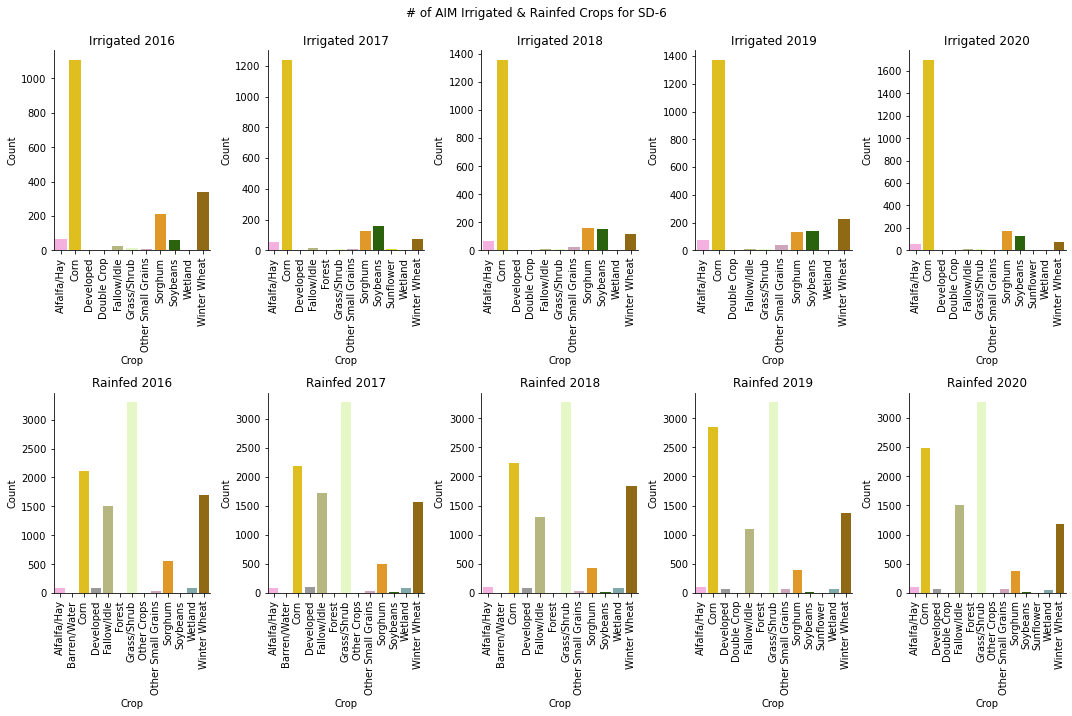

In [73]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10))
fig.suptitle('# of AIM Irrigated & Rainfed Crops for SD-6', y=0.99)
fig.patch.set_facecolor('white')

sns.countplot(ax=axs[0,0], x='CropGroup', data=irr_crop_2016, palette=crop_color)
axs[0,0].set_title("Irrigated 2016")
axs[0,0].set_xlabel("Crop")
axs[0,0].set_ylabel("Count")
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,1], x='CropGroup', data=irr_crop_2017, palette=crop_color)
axs[0,1].set_title("Irrigated 2017")
axs[0,1].set_xlabel("Crop")
axs[0,1].set_ylabel("Count")
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,2], x='CropGroup', data=irr_crop_2018, palette=crop_color)
axs[0,2].set_title("Irrigated 2018")
axs[0,2].set_xlabel("Crop")
axs[0,2].set_ylabel("Count")
axs[0,2].spines['top'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,3], x='CropGroup', data=irr_crop_2019, palette=crop_color)
axs[0,3].set_title("Irrigated 2019")
axs[0,3].set_xlabel("Crop")
axs[0,3].set_ylabel("Count")
axs[0,3].spines['top'].set_visible(False)
axs[0,3].spines['right'].set_visible(False)
axs[0,3].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,4], x='CropGroup', data=irr_crop_2020, palette=crop_color)
axs[0,4].set_title("Irrigated 2020")
axs[0,4].set_xlabel("Crop")
axs[0,4].set_ylabel("Count")
axs[0,4].spines['top'].set_visible(False)
axs[0,4].spines['right'].set_visible(False)
axs[0,4].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,0], x='CropGroup', data=rain_crop_2016, palette=crop_color)
axs[1,0].set_title("Rainfed 2016")
axs[1,0].set_xlabel("Crop")
axs[1,0].set_ylabel("Count")
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,1], x='CropGroup', data=rain_crop_2017, palette=crop_color)
axs[1,1].set_title("Rainfed 2017")
axs[1,1].set_xlabel("Crop")
axs[1,1].set_ylabel("Count")
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,2], x='CropGroup', data=rain_crop_2018, palette=crop_color)
axs[1,2].set_title("Rainfed 2018")
axs[1,2].set_xlabel("Crop")
axs[1,2].set_ylabel("Count")
axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,3], x='CropGroup', data=rain_crop_2019, palette=crop_color)
axs[1,3].set_title("Rainfed 2019")
axs[1,3].set_xlabel("Crop")
axs[1,3].set_ylabel("Count")
axs[1,3].spines['top'].set_visible(False)
axs[1,3].spines['right'].set_visible(False)
axs[1,3].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,4], x='CropGroup', data=rain_crop_2020, palette=crop_color)
axs[1,4].set_title("Rainfed 2020")
axs[1,4].set_xlabel("Crop")
axs[1,4].set_ylabel("Count")
axs[1,4].spines['top'].set_visible(False)
axs[1,4].spines['right'].set_visible(False)
axs[1,4].tick_params(axis='x', rotation=90)

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('IrrigatedRainfedCropCount.png', dpi=500)
plt.show()

### Merge aim_cdl Data with Crops

In [74]:
aim_cdl_crops = aim_cdl.merge(crops, on='CropCode')

In [75]:
aim_cdl_crops_irr = aim_cdl_crops[aim_cdl_crops['IrrigatedPrc'] >= 0.3]

In [76]:
duplicate = aim_cdl_crops_irr[aim_cdl_crops_irr.duplicated(['UID','Year'], keep=False)].sort_values('UID')
duplicate

UID  Year  IrrigatedPrc  CropCode  pctcov      CropName  \
56631    347501.0  2008         0.969         1   0.487          Corn   
152836   347501.0  2008         0.969         4   0.487       Sorghum   
126809   349849.0  2013         0.651       520   0.364   Grass/Shrub   
164600   349849.0  2013         0.651       510   0.364   Alfalfa/Hay   
29519    351319.0  2009         0.944        24   0.467  Winter Wheat   
59979    351319.0  2009         0.944         1   0.467          Corn   
16582    374066.0  2016         0.426        61   0.474   Fallow/Idle   
82528    374066.0  2016         0.426         1   0.474          Corn   
31909    374319.0  2010         0.418        24   0.451  Winter Wheat   
64375    374319.0  2010         0.418         1   0.451          Corn   
36133   1371395.0  2013         0.910        24   0.459  Winter Wheat   
164555  1371395.0  2013         0.910       510   0.459   Alfalfa/Hay   
83810   1371712.0  2017         0.964         1   0.491          Corn   
159549  1371712.0  2017         0.964         4   0.491       Sorghum   

           CropGroup  
56631           Corn  
152836       Sorghum  
126809   Grass/Shrub  
164600   Alfalfa/Hay  
29519   Winter Wheat  
59979           Corn  
16582    Fallow/Idle  
82528           Corn  
31909   Winter Wheat  
64375           Corn  
36133   Winter Wheat  
164555   Alfalfa/Hay  
83810           Corn  
159549       Sorghum

#### Time Series AIM/Crop Data

In [326]:
lema_fields = lema[['UID', 'area']]

lema_years = aim_cdl_crops[aim_cdl_crops['Year'] > 2012]
lema_years_fields = lema_years.merge(lema_fields, on='UID').set_index('CropGroup')
lema_years_fields = lema_years_fields.loc[['Corn', 'Soybeans', 'Sorghum', 'Winter Wheat', 'Double Crop', 'Alfalfa/Hay', 'Sunflower', 'Other Small Grains']]
lema_years_fields = lema_years_fields.reset_index().sort_values('CropGroup')

non_lema_years = aim_cdl_crops[aim_cdl_crops['Year'] < 2013]
non_lema_years_fields = non_lema_years.merge(lema_fields, on='UID').set_index('CropGroup')
non_lema_years_fields = non_lema_years_fields.loc[['Corn', 'Soybeans', 'Sorghum', 'Winter Wheat', 'Alfalfa/Hay', 'Sunflower']]
non_lema_years_fields = non_lema_years_fields.reset_index().sort_values('CropGroup')
lema_years_fields

CropGroup        UID  Year  IrrigatedPrc  CropCode  pctcov  \
8246   Alfalfa/Hay  1370646.0  2015         0.011       510   0.488   
8263   Alfalfa/Hay   376640.0  2020         0.950       510   0.870   
8262   Alfalfa/Hay   348537.0  2016         0.962       510   0.530   
8261   Alfalfa/Hay   349722.0  2013         0.693       510   0.958   
8260   Alfalfa/Hay   354614.0  2015         0.000       510   0.834   
...            ...        ...   ...           ...       ...     ...   
7092  Winter Wheat   351718.0  2018         0.782        24   0.883   
7091  Winter Wheat   351718.0  2015         0.000        24   0.947   
7090  Winter Wheat   351716.0  2016         0.205        24   0.467   
7102  Winter Wheat   351910.0  2013         0.000        24   0.909   
6870  Winter Wheat   378644.0  2015         0.000        24   0.999   

          CropName           area  
8246   Alfalfa/Hay   31059.409349  
8263   Alfalfa/Hay  485720.129060  
8262   Alfalfa/Hay  507830.528332  
8261   Alfalfa/Hay  265889.193973  
8260   Alfalfa/Hay  309977.175906  
...            ...            ...  
7092  Winter Wheat   33155.759316  
7091  Winter Wheat   33155.759316  
7090  Winter Wheat   31505.138704  
7102  Winter Wheat  300243.663908  
6870  Winter Wheat  224256.416603  

[8353 rows x 8 columns]

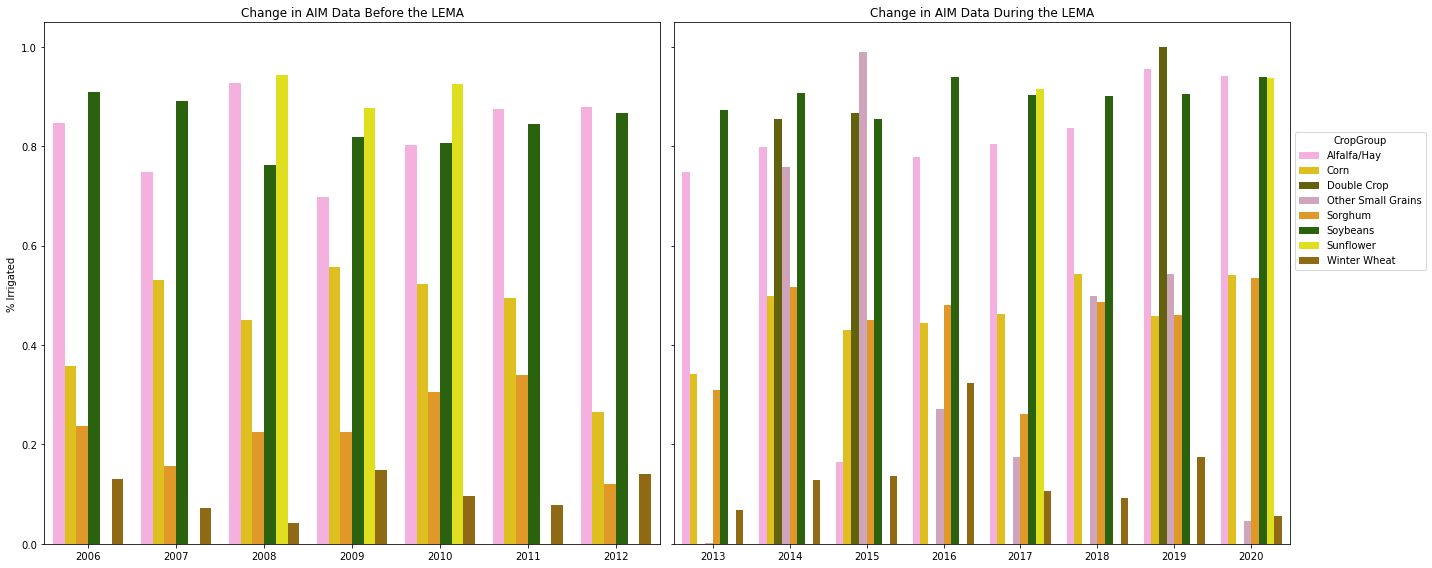

In [318]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey=True, figsize = (20, 8))
fig.patch.set_facecolor('white')

sns.barplot(ax=axs[0], x="Year", y='IrrigatedPrc', hue='CropGroup', data=non_lema_years_fields, palette=crop_color, ci=None)
sns.barplot(ax=axs[1], x="Year", y='IrrigatedPrc', hue='CropGroup', data=lema_years_fields, palette=crop_color, ci=None)
sns.move_legend(axs[1], loc="upper left", bbox_to_anchor=(1, 0.8))
axs[0].legend_.remove()
axs[1].set(ylabel=None)
axs[0].set(ylabel='% Irrigated')
axs[0].set(xlabel=None)
axs[1].set(xlabel=None)
axs[0].set_title('Change in AIM Data Before the LEMA')
axs[1].set_title('Change in AIM Data During the LEMA')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('ChangeInAIM.png', dpi=500)
plt.show()

### Time Series AIM Data Showing Irrigated Fields in LEMA

In [331]:
extract_years = aim['Year'] > 2004 # select years 2004 and up
aim_extract_years = aim.loc[extract_years] # extract those specific years from AIM data
aim_extract_years.UID = aim_extract_years.UID.astype('float') # convert to float
aim_extract_years_fields = aim_extract_years.merge(lema_fields, on='UID') # merge with LEMA fields to only get fields in LEMA
aim_extract_years_fields['area_km'] = aim_extract_years_fields['area'].div(1000000)

C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\4201715027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aim_extract_years.UID = aim_extract_years.UID.astype('float') # convert to float


In [332]:
aim_extract_years_fields

UID  Year  IrrigatedPrc           area   area_km
0      377763.0  2005         0.000  220863.203747  0.220863
1      377763.0  2006         0.000  220863.203747  0.220863
2      377763.0  2007         0.000  220863.203747  0.220863
3      377763.0  2008         0.000  220863.203747  0.220863
4      377763.0  2009         0.000  220863.203747  0.220863
...         ...   ...           ...            ...       ...
24603  377716.0  2016         0.008  221283.154099  0.221283
24604  377716.0  2017         0.002  221283.154099  0.221283
24605  377716.0  2018         0.000  221283.154099  0.221283
24606  377716.0  2019         0.017  221283.154099  0.221283
24607  377716.0  2020         0.019  221283.154099  0.221283

[24608 rows x 5 columns]

In [335]:
# Change everything above 0.49 (irrigated) to 1, everything below (rainfed) to 0
# Irrigated Fields
aim_extract_years_fields['BinaryClass'] = aim_extract_years_fields['IrrigatedPrc'].apply(lambda x: 1 if x>0.49 else 0) # add binary column
aim_extract_years_fields_irr = aim_extract_years_fields[aim_extract_years_fields['BinaryClass'] == 1] # weed out the irrigated fields only
aim_extract_years_fields_irr = aim_extract_years_fields_irr[['Year', 'BinaryClass', 'area_km']] # select columns to plot
# Rainfed Fields
aim_extract_years_fields['BinaryClass']=aim_extract_years_fields['IrrigatedPrc'].apply(lambda x: 1 if x>0.49 else 0)
aim_extract_years_fields_rain = aim_extract_years_fields[aim_extract_years_fields['BinaryClass'] == 0]
aim_extract_years_fields_rain = aim_extract_years_fields_rain[['Year', 'BinaryClass', 'area_km']]

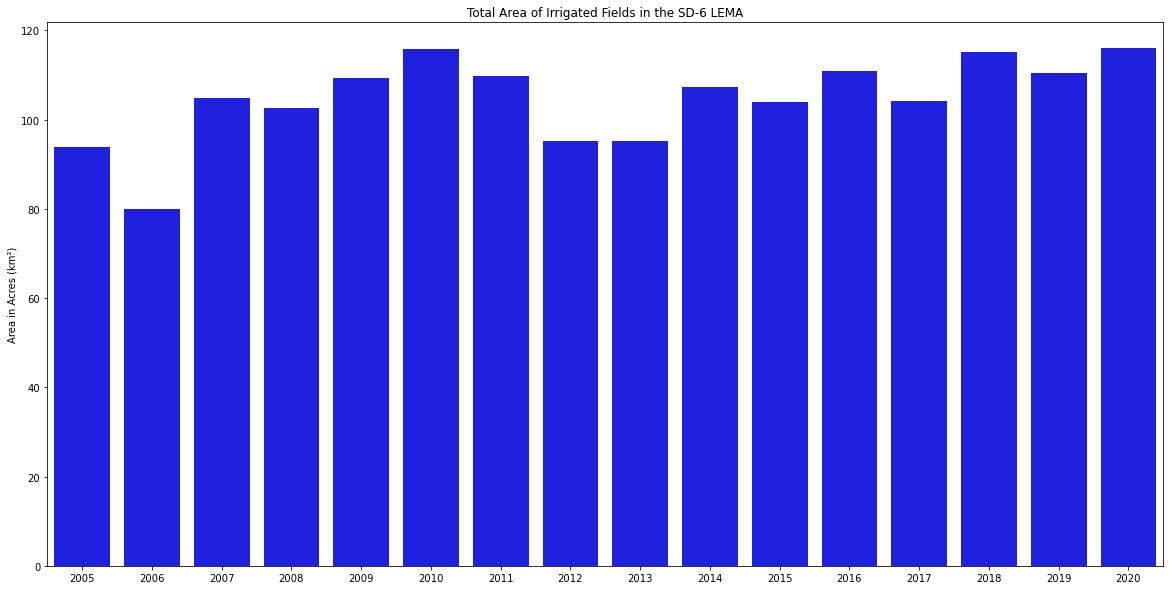

In [337]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.patch.set_facecolor('white')

sns.barplot(x='Year', y='area_km', data=aim_extract_years_fields_irr, ci=None, color='Blue', estimator=sum)
axs.set(ylabel='Area in Acres (km²)')
axs.set(xlabel=None)
# axs.vlines([2012, 2013], 0, len(aim_extract_years_fields_irr['area']))
axs.set_title('Total Area of Irrigated Fields in the SD-6 LEMA')

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('ChangeInAIM.png', dpi=500)
plt.show()

#### Confidence Check

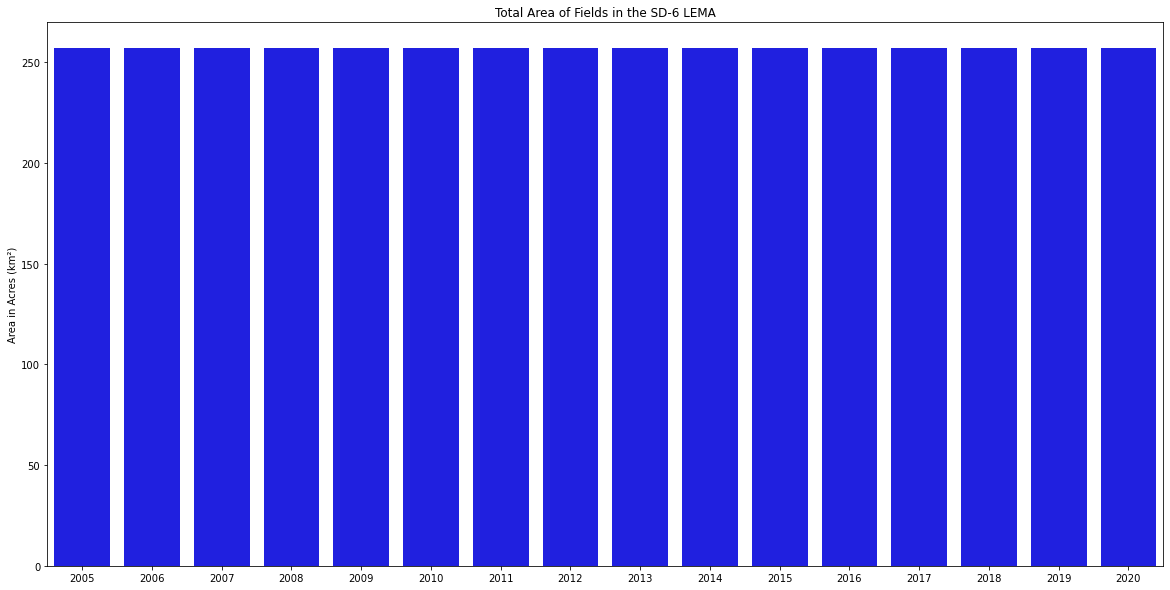

In [338]:
# Confidence Check
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.patch.set_facecolor('white')

sns.barplot(x='Year', y='area_km', data=aim_extract_years_fields, ci=None, color='Blue', estimator=sum)
axs.set(ylabel='Area in Acres (km²)')
axs.set(xlabel=None)
# axs.vlines([2012, 2013], 0, len(aim_extract_years_fields_irr['area']))
axs.set_title('Total Area of Fields in the SD-6 LEMA')

plt.show()

### Barplots for Corn and Sorghum

In [167]:
corn_sorghum = aim_cdl_crops.copy() # Create copy of df with both IrrigatedPrc and Crops
corn_sorghum.set_index("CropGroup", inplace = True)
corn_sorghum = corn_sorghum.loc[['Corn', 'Sorghum']] # Weed out corn and sorghum
corn_sorghum.reset_index(inplace=True)
corn_sorghum_lema_fields = corn_sorghum.merge(lema_fields, on='UID') # merge with just the LEMA fields

In [169]:
corn_sorghum = aim_cdl_crops.copy() # Create copy of df with both IrrigatedPrc and Crops
corn_sorghum.set_index("CropGroup", inplace = True)
corn_sorghum = corn_sorghum.loc[['Corn', 'Sorghum']] # Weed out corn and sorghum
corn_sorghum.reset_index(inplace=True)
corn_sorghum_lema_fields = corn_sorghum.merge(lema_fields, on='UID') # merge with just the LEMA fields

In [341]:
corn_sorghum_years = corn_sorghum_lema_fields[corn_sorghum_lema_fields['Year'] > 2004] # create df with years in LEMA
corn_sorghum_lema_irr = corn_sorghum_years[corn_sorghum_years['IrrigatedPrc'] > 0.49] # create df with irrigated fields in LEMA
corn_sorghum_lema_irr['area_km'] = corn_sorghum_lema_irr['area'].div(1000000)
corn_sorghum_lema_rain = corn_sorghum_years[corn_sorghum_years['IrrigatedPrc'] < 0.5]
corn_sorghum_lema_rain['area_km'] = corn_sorghum_lema_rain['area'].div(1000000)

C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\2886306518.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corn_sorghum_lema_irr['area_km'] = corn_sorghum_lema_irr['area'].div(1000000)
C:\Users\ashle\AppData\Local\Temp\ipykernel_2964\2886306518.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corn_sorghum_lema_rain['area_km'] = corn_sorghum_lema_rain['area'].div(1000000)


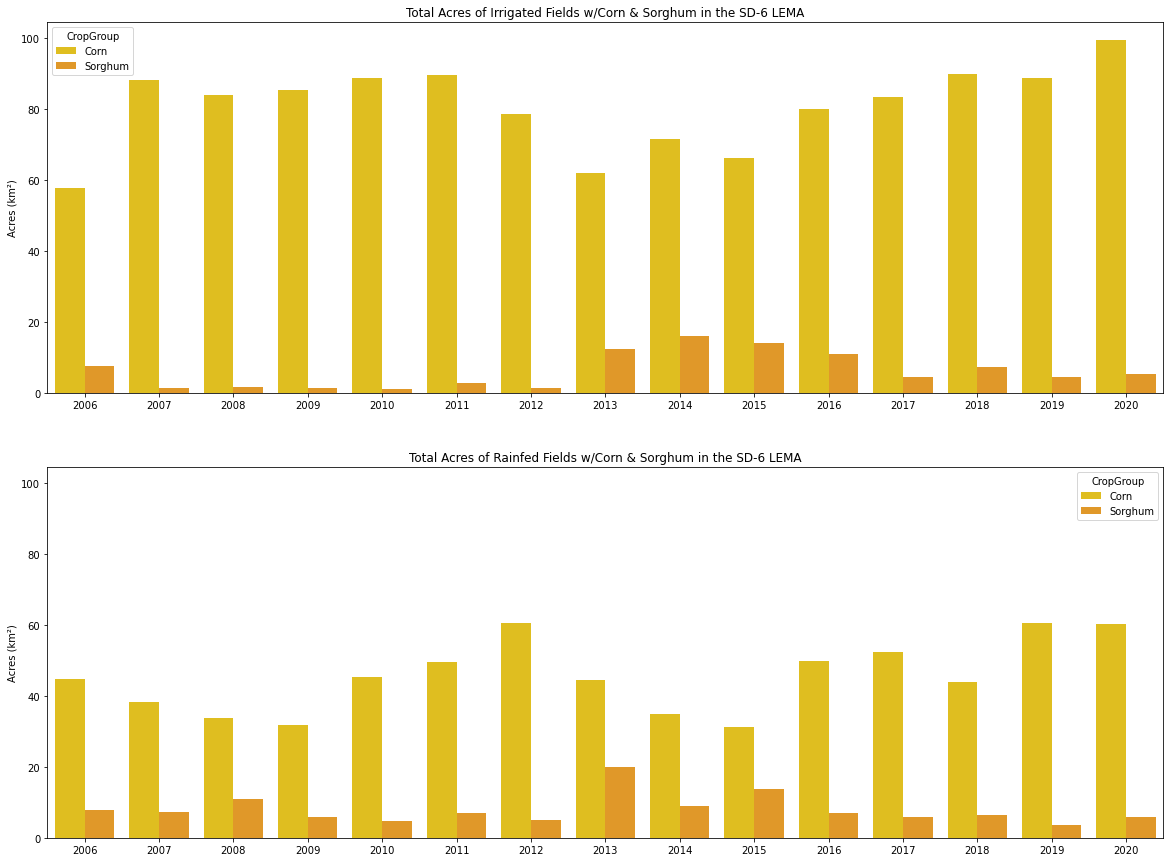

In [343]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharey=True, figsize = (20, 15))
fig.patch.set_facecolor('white')

sns.barplot(ax=axs[0], x='Year', y='area_km', hue='CropGroup', ci=None, data=corn_sorghum_lema_irr, estimator=sum, palette=crop_color)
sns.barplot(ax=axs[1], x='Year', y='area_km', hue='CropGroup', ci=None, data=corn_sorghum_lema_rain, estimator=sum, palette=crop_color)
axs[0].set(ylabel='Acres (km²)')
axs[1].set(ylabel='Acres (km²)')
axs[0].set(xlabel=None)
axs[1].set(xlabel=None)
axs[0].set_title('Total Acres of Irrigated Fields w/Corn & Sorghum in the SD-6 LEMA')
axs[1].set_title('Total Acres of Rainfed Fields w/Corn & Sorghum in the SD-6 LEMA')

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('ChangeInCornSorghum.png', dpi=500)
plt.show()

### Estimated Irrigation (mm) = ET (mean) - P Datasets

In [204]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
mean_et_list = [mean_ensemble, mean_disalexi, mean_eemetric, mean_geesebal, mean_ptjpl, mean_ssebop, mean_sims]
irr_col = ['UID', 'geometry', 'area', '2016', '2017', '2018', '2019', '2020', '2021']
mean_et_irr = ['mean_ensemble_irr', 
               'mean_disalexi_irr', 
               'mean_eemetric_irr', 
               'mean_geesebal_irr', 
               'mean_ptjpl_irr', 
               'mean_ssebop_irr', 
               'mean_sims_irr']

mean_irr = {}

for (i, x) in zip(mean_et_irr, mean_et_list):
    precip_years = precip[years] 
    mean_et = x[years]
    irr = mean_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    mean_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            precip['area'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [205]:
# Create variables easier to call
irr_mean_ensemble = mean_irr['mean_ensemble_irr']
irr_mean_disalexi = mean_irr['mean_disalexi_irr']
irr_mean_eemetric = mean_irr['mean_eemetric_irr']
irr_mean_geesebal = mean_irr['mean_geesebal_irr']
irr_mean_ptjpl = mean_irr['mean_ptjpl_irr']
irr_mean_ssebop = mean_irr['mean_ssebop_irr']
irr_mean_sims = mean_irr['mean_sims_irr']

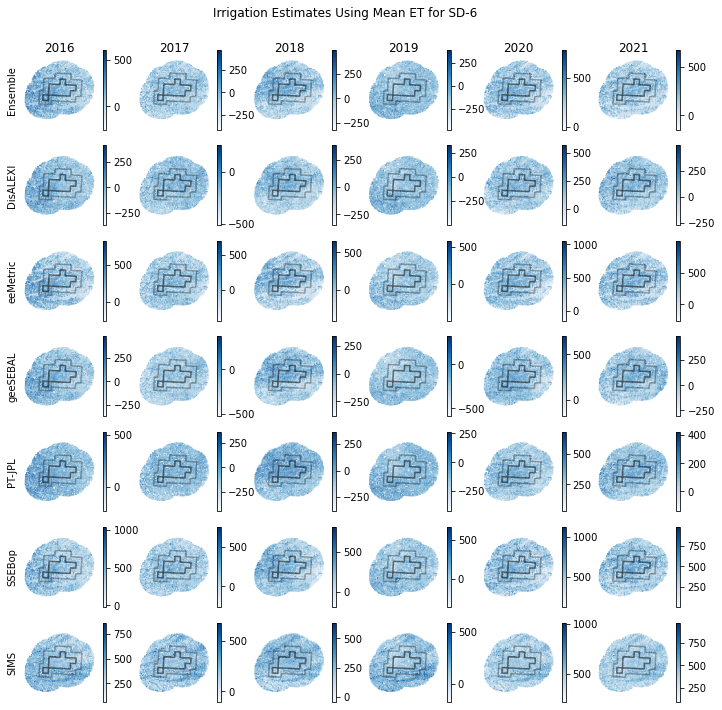

In [87]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
irr_mean_et_list = [irr_mean_ensemble, irr_mean_disalexi, irr_mean_eemetric, irr_mean_geesebal, irr_mean_ptjpl, irr_mean_ssebop, irr_mean_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Irrigation Estimates Using Mean ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = irr_mean_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

# os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
# plt.savefig('AnnualMeanETSD6.png', dpi=500)
plt.show()

### Estimated Irrigation (mm) = ET (min) - P Datasets

In [88]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
min_et_list = [min_ensemble, min_disalexi, min_eemetric, min_geesebal, min_ptjpl, min_ssebop, min_sims]
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
min_et_irr = ['min_ensemble_irr', 
               'min_disalexi_irr', 
               'min_eemetric_irr', 
               'min_geesebal_irr', 
               'min_ptjpl_irr', 
               'min_ssebop_irr', 
               'min_sims_irr']

min_irr = {}

for (i, x) in zip(min_et_irr, min_et_list):
    precip_years = precip[years] 
    min_et = x[years]
    irr = min_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    min_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [89]:
# Create variables easier to call
irr_min_ensemble = min_irr['min_ensemble_irr']
irr_min_disalexi = min_irr['min_disalexi_irr']
irr_min_eemetric = min_irr['min_eemetric_irr']
irr_min_geesebal = min_irr['min_geesebal_irr']
irr_min_ptjpl = min_irr['min_ptjpl_irr']
irr_min_ssebop = min_irr['min_ssebop_irr']
irr_min_sims = min_irr['min_sims_irr']

### Estimated Irrigation (mm) = ET (max) - P Datasets

In [90]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
max_et_list = [max_ensemble, max_disalexi, max_eemetric, max_geesebal, max_ptjpl, max_ssebop, max_sims]
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
max_et_irr = ['max_ensemble_irr', 
               'max_disalexi_irr', 
               'max_eemetric_irr', 
               'max_geesebal_irr', 
               'max_ptjpl_irr', 
               'max_ssebop_irr', 
               'max_sims_irr']

max_irr = {}

for (i, x) in zip(max_et_irr, max_et_list):
    precip_years = precip[years] 
    max_et = x[years]
    irr = max_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    max_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [91]:
# Create variables easier to call
irr_max_ensemble = max_irr['max_ensemble_irr']
irr_max_disalexi = max_irr['max_disalexi_irr']
irr_max_eemetric = max_irr['max_eemetric_irr']
irr_max_geesebal = max_irr['max_geesebal_irr']
irr_max_ptjpl = max_irr['max_ptjpl_irr']
irr_max_ssebop = max_irr['max_ssebop_irr']
irr_max_sims = max_irr['max_sims_irr']

### Confidence Intervals

Separate the levels of confidence by using these AIM thresholds:
- 0-0.35 Irrigated %: high confidence the field is rainfed
- 0.35-0.65 Irrigated %: low confidence, unsure if the field is rainfed or irrigated with the exception of the fields that share 2 crops
- 0.65-1 Irrigated %: high confidence the field is irrigated

In [98]:
aim_cdl_crops_2016 = aim_cdl_crops[aim_cdl_crops['Year'] == 2016]
aim_cdl_crops_2017 = aim_cdl_crops[aim_cdl_crops['Year'] == 2017]
aim_cdl_crops_2018 = aim_cdl_crops[aim_cdl_crops['Year'] == 2018]
aim_cdl_crops_2019 = aim_cdl_crops[aim_cdl_crops['Year'] == 2019]
aim_cdl_crops_2020 = aim_cdl_crops[aim_cdl_crops['Year'] == 2020]

In [99]:
hc_irr_2016 = aim_cdl_crops_2016[aim_cdl_crops_2016['IrrigatedPrc'] >= 0.65]
hc_rain_2016 = aim_cdl_crops_2016[aim_cdl_crops_2016['IrrigatedPrc'] <= 0.35]
lc_irr_rain_2016 = aim_cdl_crops_2016[(aim_cdl_crops_2016['IrrigatedPrc'] > 0.35) & (aim_cdl_crops_2016['IrrigatedPrc'] < 0.65)]

In [100]:
hc_irr_mean_ensemble_2016 = hc_irr_2016.merge(irr_mean_ensemble)
hc_irr_mean_ensemble_2016.drop(['Year', 'CropName', '2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
hc_rain_mean_ensemble_2016 = hc_rain_2016.merge(irr_mean_ensemble, how = 'left')
hc_rain_mean_ensemble_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
lc_mean_ensemble_2016 = lc_irr_rain_2016.merge(irr_mean_ensemble, how='left')
lc_mean_ensemble_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

In [101]:
hc_irr_mean_ensemble_corn_2016 = hc_irr_mean_ensemble_2016[hc_irr_mean_ensemble_2016['CropGroup'] == 'Corn']
hc_rain_mean_ensemble_corn_2016 = hc_rain_mean_ensemble_2016[hc_rain_mean_ensemble_2016['CropGroup'] == 'Corn']
lc_mean_ensemble_corn_2016 = lc_mean_ensemble_2016[lc_mean_ensemble_2016['CropGroup'] == 'Corn']

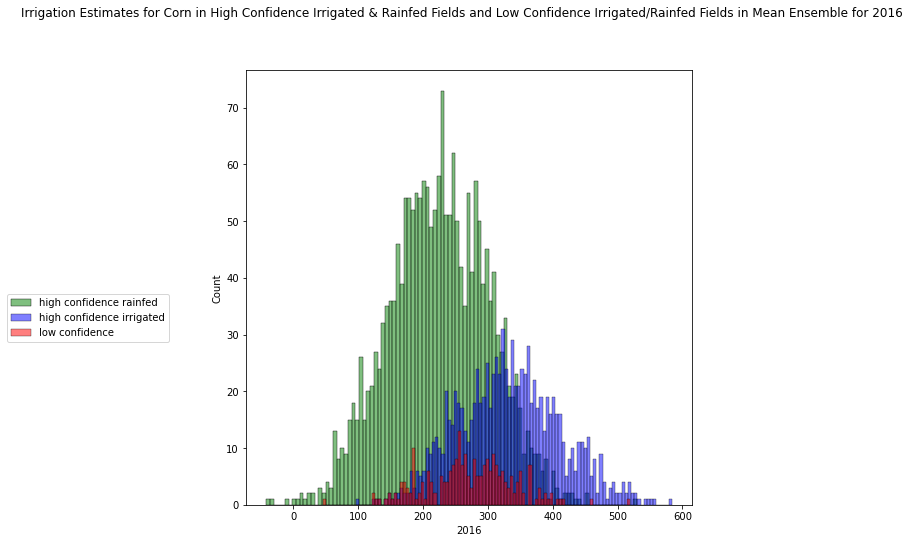

In [102]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 1, ncols = 1, sharex=True, figsize = (8, 8))
fig.suptitle('Irrigation Estimates for Corn in High Confidence Irrigated & Rainfed Fields and Low Confidence Irrigated/Rainfed Fields in Mean Ensemble for 2016', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs, 
             data=hc_rain_mean_ensemble_corn_2016, 
             x='2016', 
             alpha = 0.5, 
             bins=100, 
             label = 'high confidence rainfed', 
             color='Green')
sns.histplot(ax=axs, 
             data=hc_irr_mean_ensemble_corn_2016, 
             x='2016', 
             alpha = 0.5, 
             bins=100, 
             label = 'high confidence irrigated', 
             color='Blue')
sns.histplot(ax=axs, 
             data=lc_mean_ensemble_corn_2016, 
             x='2016', 
             alpha = 0.5, 
             bins=100, 
             label = 'low confidence', 
             color='Red')

lines, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.legend(lines, labels, 
                    loc = 'upper right', 
                    bbox_to_anchor=(0, 0., 0, 0.5))

### All Crop Histograms

These histograms show the estimated irrigation data extracted to the fields considered irrigated by the AIM data against the estimated rainfed data extracted to the fields considered rainfed by the AIM data.

In [103]:
# 2016 Mean Ensemble
irr_mean_ensemble_fields_2016 = aim_irr_2016.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ensemble_fields_2016 = aim_rain_2016.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean Ensemble
irr_mean_ensemble_fields_2017 = aim_irr_2017.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ensemble_fields_2017 = aim_rain_2017.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean Ensemble
irr_mean_ensemble_fields_2018 = aim_irr_2018.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ensemble_fields_2018 = aim_rain_2018.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean Ensemble
irr_mean_ensemble_fields_2019 = aim_irr_2019.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_ensemble_fields_2019 = aim_rain_2019.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean Ensemble
irr_mean_ensemble_fields_2020 = aim_irr_2020.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_ensemble_fields_2020 = aim_rain_2020.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [104]:
# 2016 Mean DisALEXI
irr_mean_disalexi_fields_2016 = aim_irr_2016.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_disalexi_fields_2016 = aim_rain_2016.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean DisALEXI
irr_mean_disalexi_fields_2017 = aim_irr_2017.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_disalexi_fields_2017 = aim_rain_2017.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean DisALEXI
irr_mean_disalexi_fields_2018 = aim_irr_2018.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_disalexi_fields_2018 = aim_rain_2018.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean DisALEXI
irr_mean_disalexi_fields_2019 = aim_irr_2019.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_disalexi_fields_2019 = aim_rain_2019.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean DisALEXI
irr_mean_disalexi_fields_2020 = aim_irr_2020.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_disalexi_fields_2020 = aim_rain_2020.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [105]:
# 2016 Mean eeMETRIC
irr_mean_eemetric_fields_2016 = aim_irr_2016.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_eemetric_fields_2016 = aim_rain_2016.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean eeMETRIC
irr_mean_eemetric_fields_2017 = aim_irr_2017.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_eemetric_fields_2017 = aim_rain_2017.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean eeMETRIC
irr_mean_eemetric_fields_2018 = aim_irr_2018.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_eemetric_fields_2018 = aim_rain_2018.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean eeMETRIC
irr_mean_eemetric_fields_2019 = aim_irr_2019.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_eemetric_fields_2019 = aim_rain_2019.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean eeMETRIC
irr_mean_eemetric_fields_2020 = aim_irr_2020.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_eemetric_fields_2020 = aim_rain_2020.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [106]:
# 2016 Mean geeSEBAL
irr_mean_geesebal_fields_2016 = aim_irr_2016.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_geesebal_fields_2016 = aim_rain_2016.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean geeSEBAL
irr_mean_geesebal_fields_2017 = aim_irr_2017.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_geesebal_fields_2017 = aim_rain_2017.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean geeSEBAL
irr_mean_geesebal_fields_2018 = aim_irr_2018.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_geesebal_fields_2018 = aim_rain_2018.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean geeSEBAL
irr_mean_geesebal_fields_2019 = aim_irr_2019.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_geesebal_fields_2019 = aim_rain_2019.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean geeSEBAL
irr_mean_geesebal_fields_2020 = aim_irr_2020.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_geesebal_fields_2020 = aim_rain_2020.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [107]:
# 2016 Mean PT-JPL
irr_mean_ptjpl_fields_2016 = aim_irr_2016.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ptjpl_fields_2016 = aim_rain_2016.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean PT-JPL
irr_mean_ptjpl_fields_2017 = aim_irr_2017.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ptjpl_fields_2017 = aim_rain_2017.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean PT-JPL
irr_mean_ptjpl_fields_2018 = aim_irr_2018.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ptjpl_fields_2018 = aim_rain_2018.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean PT-JPL
irr_mean_ptjpl_fields_2019 = aim_irr_2019.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_ptjpl_fields_2019 = aim_rain_2019.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean PT-JPL
irr_mean_ptjpl_fields_2020 = aim_irr_2020.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_ptjpl_fields_2020 = aim_rain_2020.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [108]:
# 2016 Mean SSEBop
irr_mean_ssebop_fields_2016 = aim_irr_2016.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ssebop_fields_2016 = aim_rain_2016.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean SSEBop
irr_mean_ssebop_fields_2017 = aim_irr_2017.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ssebop_fields_2017 = aim_rain_2017.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean SSEBop
irr_mean_ssebop_fields_2018 = aim_irr_2018.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_ssebop_fields_2018 = aim_rain_2018.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean SSEBop
irr_mean_ssebop_fields_2019 = aim_irr_2019.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_ssebop_fields_2019 = aim_rain_2019.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean SSEBop
irr_mean_ssebop_fields_2020 = aim_irr_2020.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_ssebop_fields_2020 = aim_rain_2020.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [109]:
# 2016 Mean SIMS
irr_mean_sims_fields_2016 = aim_irr_2016.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_sims_fields_2016 = aim_rain_2016.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean SIMS
irr_mean_sims_fields_2017 = aim_irr_2017.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_sims_fields_2017 = aim_rain_2017.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean SIMS
irr_mean_sims_fields_2018 = aim_irr_2018.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)
rain_mean_sims_fields_2018 = aim_rain_2018.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean SIMS
irr_mean_sims_fields_2019 = aim_irr_2019.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)
rain_mean_sims_fields_2019 = aim_rain_2019.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean SIMS
irr_mean_sims_fields_2020 = aim_irr_2020.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)
rain_mean_sims_fields_2020 = aim_rain_2020.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

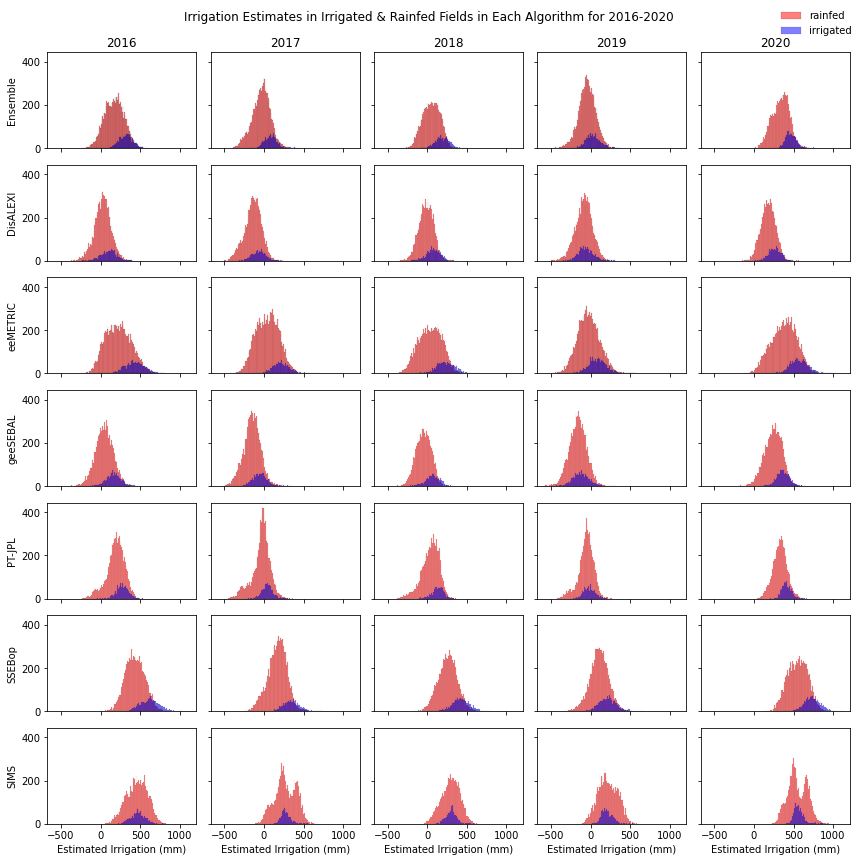

In [110]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 5, sharex=True, sharey=True, figsize = (12, 12))
fig.suptitle('Irrigation Estimates in Irrigated & Rainfed Fields in Each Algorithm for 2016-2020', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs[0,0], data=rain_mean_ensemble_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,0], data=irr_mean_ensemble_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,1], data=rain_mean_ensemble_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,1], data=irr_mean_ensemble_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,2], data=rain_mean_ensemble_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,2], data=irr_mean_ensemble_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,3], data=rain_mean_ensemble_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,3], data=irr_mean_ensemble_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,4], data=rain_mean_ensemble_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,4], data=irr_mean_ensemble_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,0], data=rain_mean_disalexi_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,0], data=irr_mean_disalexi_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,1], data=rain_mean_disalexi_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,1], data=irr_mean_disalexi_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,2], data=rain_mean_disalexi_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,2], data=irr_mean_disalexi_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,3], data=rain_mean_disalexi_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,3], data=irr_mean_disalexi_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,4], data=rain_mean_disalexi_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,4], data=irr_mean_disalexi_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,0], data=rain_mean_eemetric_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,0], data=irr_mean_eemetric_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,1], data=rain_mean_eemetric_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,1], data=irr_mean_eemetric_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,2], data=rain_mean_eemetric_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,2], data=irr_mean_eemetric_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,3], data=rain_mean_eemetric_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,3], data=irr_mean_eemetric_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,4], data=rain_mean_eemetric_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,4], data=irr_mean_eemetric_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,0], data=rain_mean_geesebal_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,0], data=irr_mean_geesebal_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,1], data=rain_mean_geesebal_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,1], data=irr_mean_geesebal_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,2], data=rain_mean_geesebal_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,2], data=irr_mean_geesebal_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,3], data=rain_mean_geesebal_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,3], data=irr_mean_geesebal_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,4], data=rain_mean_geesebal_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,4], data=irr_mean_geesebal_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,0], data=rain_mean_ptjpl_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,0], data=irr_mean_ptjpl_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,1], data=rain_mean_ptjpl_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,1], data=irr_mean_ptjpl_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,2], data=rain_mean_ptjpl_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,2], data=irr_mean_ptjpl_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,3], data=rain_mean_ptjpl_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,3], data=irr_mean_ptjpl_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,4], data=rain_mean_ptjpl_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,4], data=irr_mean_ptjpl_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,0], data=rain_mean_ssebop_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,0], data=irr_mean_ssebop_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,1], data=rain_mean_ssebop_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,1], data=irr_mean_ssebop_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,2], data=rain_mean_ssebop_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,2], data=irr_mean_ssebop_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,3], data=rain_mean_ssebop_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,3], data=irr_mean_ssebop_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,4], data=rain_mean_ssebop_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,4], data=irr_mean_ssebop_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,0], data=rain_mean_sims_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,0], data=irr_mean_sims_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,1], data=rain_mean_sims_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,1], data=irr_mean_sims_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,2], data=rain_mean_sims_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,2], data=irr_mean_sims_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,3], data=rain_mean_sims_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,3], data=irr_mean_sims_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,4], data=rain_mean_sims_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,4], data=irr_mean_sims_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
ax=axs[0,0].set_ylabel('Ensemble')
ax=axs[0,1].set_ylabel('')
ax=axs[0,2].set_ylabel('')
ax=axs[0,3].set_ylabel('')
ax=axs[0,4].set_ylabel('')
ax=axs[1,0].set_ylabel('DisALEXI')
ax=axs[1,1].set_ylabel('')
ax=axs[1,2].set_ylabel('')
ax=axs[1,3].set_ylabel('')
ax=axs[1,4].set_ylabel('')
ax=axs[2,0].set_ylabel('eeMETRIC')
ax=axs[2,1].set_ylabel('')
ax=axs[2,2].set_ylabel('')
ax=axs[2,3].set_ylabel('')
ax=axs[2,4].set_ylabel('')
ax=axs[3,0].set_ylabel('geeSEBAL')
ax=axs[3,1].set_ylabel('')
ax=axs[3,2].set_ylabel('')
ax=axs[3,3].set_ylabel('')
ax=axs[3,4].set_ylabel('')
ax=axs[4,0].set_ylabel('PT-JPL')
ax=axs[4,1].set_ylabel('')
ax=axs[4,2].set_ylabel('')
ax=axs[4,3].set_ylabel('')
ax=axs[4,4].set_ylabel('')
ax=axs[5,0].set_ylabel('SSEBop')
ax=axs[5,1].set_ylabel('')
ax=axs[5,2].set_ylabel('')
ax=axs[5,3].set_ylabel('')
ax=axs[5,4].set_ylabel('')
ax=axs[6,0].set_ylabel('SIMS')
ax=axs[6,1].set_ylabel('')
ax=axs[6,2].set_ylabel('')
ax=axs[6,3].set_ylabel('')
ax=axs[6,4].set_ylabel('')
ax=axs[0,0].set_xlabel('')
ax=axs[0,1].set_xlabel('')
ax=axs[0,2].set_xlabel('')
ax=axs[0,3].set_xlabel('')
ax=axs[0,4].set_xlabel('')
ax=axs[1,0].set_xlabel('')
ax=axs[1,1].set_xlabel('')
ax=axs[1,2].set_xlabel('')
ax=axs[1,3].set_xlabel('')
ax=axs[1,4].set_xlabel('')
ax=axs[2,0].set_xlabel('')
ax=axs[2,1].set_xlabel('')
ax=axs[2,2].set_xlabel('')
ax=axs[2,3].set_xlabel('')
ax=axs[2,4].set_xlabel('')
ax=axs[3,0].set_xlabel('')
ax=axs[3,1].set_xlabel('')
ax=axs[3,2].set_xlabel('')
ax=axs[3,3].set_xlabel('')
ax=axs[3,4].set_xlabel('')
ax=axs[4,1].set_xlabel('')
ax=axs[4,2].set_xlabel('')
ax=axs[4,3].set_xlabel('')
ax=axs[4,4].set_xlabel('')
ax=axs[5,0].set_xlabel('')
ax=axs[5,1].set_xlabel('')
ax=axs[5,2].set_xlabel('')
ax=axs[5,3].set_xlabel('')
ax=axs[5,4].set_xlabel('')
ax=axs[6,0].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,1].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,2].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,3].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,4].set_xlabel('Estimated Irrigation (mm)')
axs[0,0].set_title('2016')
axs[0,1].set_title('2017')
axs[0,2].set_title('2018')
axs[0,3].set_title('2019')
axs[0,4].set_title('2020')

lines, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.legend(lines, labels, loc = 'upper right', bbox_to_anchor=(0.0005, 0., 1, 1))

frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_edgecolor('none')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('fieldsIrrigationEstimates.png', dpi=500)
plt.show()

### Corn Histograms

Subset the data to the fields only producing corn by algorithm

In [113]:
cdl_2016 = cdl[cdl['Year']==2016]
cdl_2017 = cdl[cdl['Year']==2017]
cdl_2018 = cdl[cdl['Year']==2018]
cdl_2019 = cdl[cdl['Year']==2019]
cdl_2020 = cdl[cdl['Year']==2020]

cdl_years = [cdl_2016, cdl_2017, cdl_2018, cdl_2019, cdl_2020]

In [114]:
# Irrigated Corn Mean Ensemble
irr_corn_mean_ensemble = {}

irr_mean_ensemble_fields = [irr_mean_ensemble_fields_2016, 
                            irr_mean_ensemble_fields_2017, 
                            irr_mean_ensemble_fields_2018, 
                            irr_mean_ensemble_fields_2019, 
                            irr_mean_ensemble_fields_2020]
irr_corn_mean_ensemble_lab = ['corn_irr_mean_ensemble_2016', 
                              'corn_irr_mean_ensemble_2017', 
                              'corn_irr_mean_ensemble_2018', 
                              'corn_irr_mean_ensemble_2019', 
                              'corn_irr_mean_ensemble_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ensemble_fields, irr_corn_mean_ensemble_lab):
    irr_mean_ensemble_corn = y.merge(x, on='UID')
    irr_mean_ensemble_corn = irr_mean_ensemble_corn.merge(crops, on='CropCode')
    irr_corn_mean_ensemble[z] = irr_mean_ensemble_corn[irr_mean_ensemble_corn['CropGroup'] == 'Corn']
    
irr_mean_ensemble_corn_2016 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2016']
irr_mean_ensemble_corn_2017 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2017']
irr_mean_ensemble_corn_2018 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2018']
irr_mean_ensemble_corn_2019 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2019']
irr_mean_ensemble_corn_2020 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2020']

# Rainfed Corn Mean Ensemble
rain_corn_mean_ensemble = {}

rain_mean_ensemble_fields = [rain_mean_ensemble_fields_2016, 
                            rain_mean_ensemble_fields_2017, 
                            rain_mean_ensemble_fields_2018, 
                            rain_mean_ensemble_fields_2019, 
                            rain_mean_ensemble_fields_2020]
rain_corn_mean_ensemble_lab = ['corn_rain_mean_ensemble_2016', 
                              'corn_rain_mean_ensemble_2017', 
                              'corn_rain_mean_ensemble_2018', 
                              'corn_rain_mean_ensemble_2019', 
                              'corn_rain_mean_ensemble_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ensemble_fields, rain_corn_mean_ensemble_lab):
    rain_mean_ensemble_corn = y.merge(x, on='UID')
    rain_mean_ensemble_corn = rain_mean_ensemble_corn.merge(crops, on='CropCode')
    rain_corn_mean_ensemble[z] = rain_mean_ensemble_corn[rain_mean_ensemble_corn['CropGroup'] == 'Corn']
    
rain_mean_ensemble_corn_2016 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2016']
rain_mean_ensemble_corn_2017 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2017']
rain_mean_ensemble_corn_2018 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2018']
rain_mean_ensemble_corn_2019 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2019']
rain_mean_ensemble_corn_2020 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2020']

In [115]:
# Irrigated Corn Mean disalexi
irr_corn_mean_disalexi = {}

irr_mean_disalexi_fields = [irr_mean_disalexi_fields_2016, 
                            irr_mean_disalexi_fields_2017, 
                            irr_mean_disalexi_fields_2018, 
                            irr_mean_disalexi_fields_2019, 
                            irr_mean_disalexi_fields_2020]
irr_corn_mean_disalexi_lab = ['corn_irr_mean_disalexi_2016', 
                              'corn_irr_mean_disalexi_2017', 
                              'corn_irr_mean_disalexi_2018', 
                              'corn_irr_mean_disalexi_2019', 
                              'corn_irr_mean_disalexi_2020']

for (x, y, z) in zip(cdl_years, irr_mean_disalexi_fields, irr_corn_mean_disalexi_lab):
    irr_mean_disalexi_corn = y.merge(x, on='UID')
    irr_mean_disalexi_corn = irr_mean_disalexi_corn.merge(crops, on='CropCode')
    irr_corn_mean_disalexi[z] = irr_mean_disalexi_corn[irr_mean_disalexi_corn['CropGroup'] == 'Corn']
    
irr_mean_disalexi_corn_2016 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2016']
irr_mean_disalexi_corn_2017 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2017']
irr_mean_disalexi_corn_2018 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2018']
irr_mean_disalexi_corn_2019 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2019']
irr_mean_disalexi_corn_2020 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2020']

# Rainfed Corn Mean disalexi
rain_corn_mean_disalexi = {}

rain_mean_disalexi_fields = [rain_mean_disalexi_fields_2016, 
                            rain_mean_disalexi_fields_2017, 
                            rain_mean_disalexi_fields_2018, 
                            rain_mean_disalexi_fields_2019, 
                            rain_mean_disalexi_fields_2020]
rain_corn_mean_disalexi_lab = ['corn_rain_mean_disalexi_2016', 
                              'corn_rain_mean_disalexi_2017', 
                              'corn_rain_mean_disalexi_2018', 
                              'corn_rain_mean_disalexi_2019', 
                              'corn_rain_mean_disalexi_2020']

for (x, y, z) in zip(cdl_years, rain_mean_disalexi_fields, rain_corn_mean_disalexi_lab):
    rain_mean_disalexi_corn = y.merge(x, on='UID')
    rain_mean_disalexi_corn = rain_mean_disalexi_corn.merge(crops, on='CropCode')
    rain_corn_mean_disalexi[z] = rain_mean_disalexi_corn[rain_mean_disalexi_corn['CropGroup'] == 'Corn']
    
rain_mean_disalexi_corn_2016 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2016']
rain_mean_disalexi_corn_2017 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2017']
rain_mean_disalexi_corn_2018 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2018']
rain_mean_disalexi_corn_2019 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2019']
rain_mean_disalexi_corn_2020 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2020']

In [116]:
# Irrigated Corn Mean eemetric
irr_corn_mean_eemetric = {}

irr_mean_eemetric_fields = [irr_mean_eemetric_fields_2016, 
                            irr_mean_eemetric_fields_2017, 
                            irr_mean_eemetric_fields_2018, 
                            irr_mean_eemetric_fields_2019, 
                            irr_mean_eemetric_fields_2020]
irr_corn_mean_eemetric_lab = ['corn_irr_mean_eemetric_2016', 
                              'corn_irr_mean_eemetric_2017', 
                              'corn_irr_mean_eemetric_2018', 
                              'corn_irr_mean_eemetric_2019', 
                              'corn_irr_mean_eemetric_2020']

for (x, y, z) in zip(cdl_years, irr_mean_eemetric_fields, irr_corn_mean_eemetric_lab):
    irr_mean_eemetric_corn = y.merge(x, on='UID')
    irr_mean_eemetric_corn = irr_mean_eemetric_corn.merge(crops, on='CropCode')
    irr_corn_mean_eemetric[z] = irr_mean_eemetric_corn[irr_mean_eemetric_corn['CropGroup'] == 'Corn']
    
irr_mean_eemetric_corn_2016 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2016']
irr_mean_eemetric_corn_2017 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2017']
irr_mean_eemetric_corn_2018 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2018']
irr_mean_eemetric_corn_2019 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2019']
irr_mean_eemetric_corn_2020 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2020']

# Rainfed Corn Mean eemetric
rain_corn_mean_eemetric = {}

rain_mean_eemetric_fields = [rain_mean_eemetric_fields_2016, 
                            rain_mean_eemetric_fields_2017, 
                            rain_mean_eemetric_fields_2018, 
                            rain_mean_eemetric_fields_2019, 
                            rain_mean_eemetric_fields_2020]
rain_corn_mean_eemetric_lab = ['corn_rain_mean_eemetric_2016', 
                              'corn_rain_mean_eemetric_2017', 
                              'corn_rain_mean_eemetric_2018', 
                              'corn_rain_mean_eemetric_2019', 
                              'corn_rain_mean_eemetric_2020']

for (x, y, z) in zip(cdl_years, rain_mean_eemetric_fields, rain_corn_mean_eemetric_lab):
    rain_mean_eemetric_corn = y.merge(x, on='UID')
    rain_mean_eemetric_corn = rain_mean_eemetric_corn.merge(crops, on='CropCode')
    rain_corn_mean_eemetric[z] = rain_mean_eemetric_corn[rain_mean_eemetric_corn['CropGroup'] == 'Corn']
    
rain_mean_eemetric_corn_2016 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2016']
rain_mean_eemetric_corn_2017 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2017']
rain_mean_eemetric_corn_2018 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2018']
rain_mean_eemetric_corn_2019 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2019']
rain_mean_eemetric_corn_2020 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2020']

In [117]:
# Irrigated Corn Mean geesebal
irr_corn_mean_geesebal = {}

irr_mean_geesebal_fields = [irr_mean_geesebal_fields_2016, 
                            irr_mean_geesebal_fields_2017, 
                            irr_mean_geesebal_fields_2018, 
                            irr_mean_geesebal_fields_2019, 
                            irr_mean_geesebal_fields_2020]
irr_corn_mean_geesebal_lab = ['corn_irr_mean_geesebal_2016', 
                              'corn_irr_mean_geesebal_2017', 
                              'corn_irr_mean_geesebal_2018', 
                              'corn_irr_mean_geesebal_2019', 
                              'corn_irr_mean_geesebal_2020']

for (x, y, z) in zip(cdl_years, irr_mean_geesebal_fields, irr_corn_mean_geesebal_lab):
    irr_mean_geesebal_corn = y.merge(x, on='UID')
    irr_mean_geesebal_corn = irr_mean_geesebal_corn.merge(crops, on='CropCode')
    irr_corn_mean_geesebal[z] = irr_mean_geesebal_corn[irr_mean_geesebal_corn['CropGroup'] == 'Corn']
    
irr_mean_geesebal_corn_2016 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2016']
irr_mean_geesebal_corn_2017 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2017']
irr_mean_geesebal_corn_2018 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2018']
irr_mean_geesebal_corn_2019 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2019']
irr_mean_geesebal_corn_2020 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2020']

# Rainfed Corn Mean geesebal
rain_corn_mean_geesebal = {}

rain_mean_geesebal_fields = [rain_mean_geesebal_fields_2016, 
                            rain_mean_geesebal_fields_2017, 
                            rain_mean_geesebal_fields_2018, 
                            rain_mean_geesebal_fields_2019, 
                            rain_mean_geesebal_fields_2020]
rain_corn_mean_geesebal_lab = ['corn_rain_mean_geesebal_2016', 
                              'corn_rain_mean_geesebal_2017', 
                              'corn_rain_mean_geesebal_2018', 
                              'corn_rain_mean_geesebal_2019', 
                              'corn_rain_mean_geesebal_2020']

for (x, y, z) in zip(cdl_years, rain_mean_geesebal_fields, rain_corn_mean_geesebal_lab):
    rain_mean_geesebal_corn = y.merge(x, on='UID')
    rain_mean_geesebal_corn = rain_mean_geesebal_corn.merge(crops, on='CropCode')
    rain_corn_mean_geesebal[z] = rain_mean_geesebal_corn[rain_mean_geesebal_corn['CropGroup'] == 'Corn']
    
rain_mean_geesebal_corn_2016 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2016']
rain_mean_geesebal_corn_2017 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2017']
rain_mean_geesebal_corn_2018 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2018']
rain_mean_geesebal_corn_2019 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2019']
rain_mean_geesebal_corn_2020 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2020']

In [118]:
# Irrigated Corn Mean ptjpl
irr_corn_mean_ptjpl = {}

irr_mean_ptjpl_fields = [irr_mean_ptjpl_fields_2016, 
                            irr_mean_ptjpl_fields_2017, 
                            irr_mean_ptjpl_fields_2018, 
                            irr_mean_ptjpl_fields_2019, 
                            irr_mean_ptjpl_fields_2020]
irr_corn_mean_ptjpl_lab = ['corn_irr_mean_ptjpl_2016', 
                              'corn_irr_mean_ptjpl_2017', 
                              'corn_irr_mean_ptjpl_2018', 
                              'corn_irr_mean_ptjpl_2019', 
                              'corn_irr_mean_ptjpl_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ptjpl_fields, irr_corn_mean_ptjpl_lab):
    irr_mean_ptjpl_corn = y.merge(x, on='UID')
    irr_mean_ptjpl_corn = irr_mean_ptjpl_corn.merge(crops, on='CropCode')
    irr_corn_mean_ptjpl[z] = irr_mean_ptjpl_corn[irr_mean_ptjpl_corn['CropGroup'] == 'Corn']
    
irr_mean_ptjpl_corn_2016 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2016']
irr_mean_ptjpl_corn_2017 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2017']
irr_mean_ptjpl_corn_2018 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2018']
irr_mean_ptjpl_corn_2019 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2019']
irr_mean_ptjpl_corn_2020 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2020']

# Rainfed Corn Mean ptjpl
rain_corn_mean_ptjpl = {}

rain_mean_ptjpl_fields = [rain_mean_ptjpl_fields_2016, 
                            rain_mean_ptjpl_fields_2017, 
                            rain_mean_ptjpl_fields_2018, 
                            rain_mean_ptjpl_fields_2019, 
                            rain_mean_ptjpl_fields_2020]
rain_corn_mean_ptjpl_lab = ['corn_rain_mean_ptjpl_2016', 
                              'corn_rain_mean_ptjpl_2017', 
                              'corn_rain_mean_ptjpl_2018', 
                              'corn_rain_mean_ptjpl_2019', 
                              'corn_rain_mean_ptjpl_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ptjpl_fields, rain_corn_mean_ptjpl_lab):
    rain_mean_ptjpl_corn = y.merge(x, on='UID')
    rain_mean_ptjpl_corn = rain_mean_ptjpl_corn.merge(crops, on='CropCode')
    rain_corn_mean_ptjpl[z] = rain_mean_ptjpl_corn[rain_mean_ptjpl_corn['CropGroup'] == 'Corn']
    
rain_mean_ptjpl_corn_2016 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2016']
rain_mean_ptjpl_corn_2017 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2017']
rain_mean_ptjpl_corn_2018 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2018']
rain_mean_ptjpl_corn_2019 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2019']
rain_mean_ptjpl_corn_2020 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2020']

In [119]:
# Irrigated Corn Mean ssebop
irr_corn_mean_ssebop = {}

irr_mean_ssebop_fields = [irr_mean_ssebop_fields_2016, 
                            irr_mean_ssebop_fields_2017, 
                            irr_mean_ssebop_fields_2018, 
                            irr_mean_ssebop_fields_2019, 
                            irr_mean_ssebop_fields_2020]
irr_corn_mean_ssebop_lab = ['corn_irr_mean_ssebop_2016', 
                              'corn_irr_mean_ssebop_2017', 
                              'corn_irr_mean_ssebop_2018', 
                              'corn_irr_mean_ssebop_2019', 
                              'corn_irr_mean_ssebop_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ssebop_fields, irr_corn_mean_ssebop_lab):
    irr_mean_ssebop_corn = y.merge(x, on='UID')
    irr_mean_ssebop_corn = irr_mean_ssebop_corn.merge(crops, on='CropCode')
    irr_corn_mean_ssebop[z] = irr_mean_ssebop_corn[irr_mean_ssebop_corn['CropGroup'] == 'Corn']
    
irr_mean_ssebop_corn_2016 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2016']
irr_mean_ssebop_corn_2017 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2017']
irr_mean_ssebop_corn_2018 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2018']
irr_mean_ssebop_corn_2019 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2019']
irr_mean_ssebop_corn_2020 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2020']

# Rainfed Corn Mean ssebop
rain_corn_mean_ssebop = {}

rain_mean_ssebop_fields = [rain_mean_ssebop_fields_2016, 
                            rain_mean_ssebop_fields_2017, 
                            rain_mean_ssebop_fields_2018, 
                            rain_mean_ssebop_fields_2019, 
                            rain_mean_ssebop_fields_2020]
rain_corn_mean_ssebop_lab = ['corn_rain_mean_ssebop_2016', 
                              'corn_rain_mean_ssebop_2017', 
                              'corn_rain_mean_ssebop_2018', 
                              'corn_rain_mean_ssebop_2019', 
                              'corn_rain_mean_ssebop_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ssebop_fields, rain_corn_mean_ssebop_lab):
    rain_mean_ssebop_corn = y.merge(x, on='UID')
    rain_mean_ssebop_corn = rain_mean_ssebop_corn.merge(crops, on='CropCode')
    rain_corn_mean_ssebop[z] = rain_mean_ssebop_corn[rain_mean_ssebop_corn['CropGroup'] == 'Corn']
    
rain_mean_ssebop_corn_2016 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2016']
rain_mean_ssebop_corn_2017 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2017']
rain_mean_ssebop_corn_2018 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2018']
rain_mean_ssebop_corn_2019 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2019']
rain_mean_ssebop_corn_2020 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2020']

In [120]:
# Irrigated Corn Mean sims
irr_corn_mean_sims = {}

irr_mean_sims_fields = [irr_mean_sims_fields_2016, 
                            irr_mean_sims_fields_2017, 
                            irr_mean_sims_fields_2018, 
                            irr_mean_sims_fields_2019, 
                            irr_mean_sims_fields_2020]
irr_corn_mean_sims_lab = ['corn_irr_mean_sims_2016', 
                              'corn_irr_mean_sims_2017', 
                              'corn_irr_mean_sims_2018', 
                              'corn_irr_mean_sims_2019', 
                              'corn_irr_mean_sims_2020']

for (x, y, z) in zip(cdl_years, irr_mean_sims_fields, irr_corn_mean_sims_lab):
    irr_mean_sims_corn = y.merge(x, on='UID')
    irr_mean_sims_corn = irr_mean_sims_corn.merge(crops, on='CropCode')
    irr_corn_mean_sims[z] = irr_mean_sims_corn[irr_mean_sims_corn['CropGroup'] == 'Corn']
    
irr_mean_sims_corn_2016 = irr_corn_mean_sims['corn_irr_mean_sims_2016']
irr_mean_sims_corn_2017 = irr_corn_mean_sims['corn_irr_mean_sims_2017']
irr_mean_sims_corn_2018 = irr_corn_mean_sims['corn_irr_mean_sims_2018']
irr_mean_sims_corn_2019 = irr_corn_mean_sims['corn_irr_mean_sims_2019']
irr_mean_sims_corn_2020 = irr_corn_mean_sims['corn_irr_mean_sims_2020']

# Rainfed Corn Mean sims
rain_corn_mean_sims = {}

rain_mean_sims_fields = [rain_mean_sims_fields_2016, 
                            rain_mean_sims_fields_2017, 
                            rain_mean_sims_fields_2018, 
                            rain_mean_sims_fields_2019, 
                            rain_mean_sims_fields_2020]
rain_corn_mean_sims_lab = ['corn_rain_mean_sims_2016', 
                              'corn_rain_mean_sims_2017', 
                              'corn_rain_mean_sims_2018', 
                              'corn_rain_mean_sims_2019', 
                              'corn_rain_mean_sims_2020']

for (x, y, z) in zip(cdl_years, rain_mean_sims_fields, rain_corn_mean_sims_lab):
    rain_mean_sims_corn = y.merge(x, on='UID')
    rain_mean_sims_corn = rain_mean_sims_corn.merge(crops, on='CropCode')
    rain_corn_mean_sims[z] = rain_mean_sims_corn[rain_mean_sims_corn['CropGroup'] == 'Corn']
    
rain_mean_sims_corn_2016 = rain_corn_mean_sims['corn_rain_mean_sims_2016']
rain_mean_sims_corn_2017 = rain_corn_mean_sims['corn_rain_mean_sims_2017']
rain_mean_sims_corn_2018 = rain_corn_mean_sims['corn_rain_mean_sims_2018']
rain_mean_sims_corn_2019 = rain_corn_mean_sims['corn_rain_mean_sims_2019']
rain_mean_sims_corn_2020 = rain_corn_mean_sims['corn_rain_mean_sims_2020']

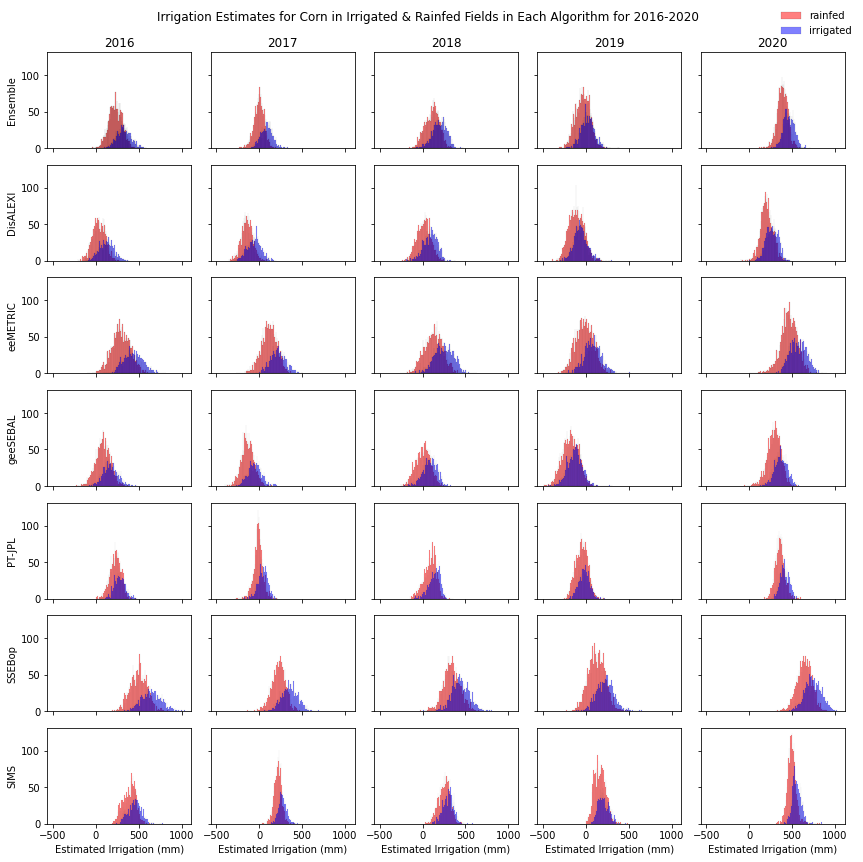

In [121]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 5, sharey= True, sharex=True, figsize = (12, 12))
fig.suptitle('Irrigation Estimates for Corn in Irrigated & Rainfed Fields in Each Algorithm for 2016-2020', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs[0,0], data=rain_mean_ensemble_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,0], data=irr_mean_ensemble_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,1], data=rain_mean_ensemble_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,1], data=irr_mean_ensemble_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,2], data=rain_mean_ensemble_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,2], data=irr_mean_ensemble_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,3], data=rain_mean_ensemble_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,3], data=irr_mean_ensemble_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,4], data=rain_mean_ensemble_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,4], data=irr_mean_ensemble_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,0], data=rain_mean_disalexi_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,0], data=irr_mean_disalexi_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,1], data=rain_mean_disalexi_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,1], data=irr_mean_disalexi_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,2], data=rain_mean_disalexi_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,2], data=irr_mean_disalexi_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,3], data=rain_mean_disalexi_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,3], data=irr_mean_disalexi_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,4], data=rain_mean_disalexi_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,4], data=irr_mean_disalexi_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,0], data=rain_mean_eemetric_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,0], data=irr_mean_eemetric_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,1], data=rain_mean_eemetric_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,1], data=irr_mean_eemetric_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,2], data=rain_mean_eemetric_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,2], data=irr_mean_eemetric_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,3], data=rain_mean_eemetric_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,3], data=irr_mean_eemetric_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,4], data=rain_mean_eemetric_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,4], data=irr_mean_eemetric_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,0], data=rain_mean_geesebal_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,0], data=irr_mean_geesebal_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,1], data=rain_mean_geesebal_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,1], data=irr_mean_geesebal_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,2], data=rain_mean_geesebal_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,2], data=irr_mean_geesebal_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,3], data=rain_mean_geesebal_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,3], data=irr_mean_geesebal_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,4], data=rain_mean_geesebal_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,4], data=irr_mean_geesebal_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,0], data=rain_mean_ptjpl_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,0], data=irr_mean_ptjpl_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,1], data=rain_mean_ptjpl_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,1], data=irr_mean_ptjpl_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,2], data=rain_mean_ptjpl_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,2], data=irr_mean_ptjpl_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,3], data=rain_mean_ptjpl_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,3], data=irr_mean_ptjpl_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,4], data=rain_mean_ptjpl_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,4], data=irr_mean_ptjpl_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,0], data=rain_mean_ssebop_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,0], data=irr_mean_ssebop_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,1], data=rain_mean_ssebop_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,1], data=irr_mean_ssebop_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,2], data=rain_mean_ssebop_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,2], data=irr_mean_ssebop_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,3], data=rain_mean_ssebop_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,3], data=irr_mean_ssebop_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,4], data=rain_mean_ssebop_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,4], data=irr_mean_ssebop_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,0], data=rain_mean_sims_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,0], data=irr_mean_sims_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,1], data=rain_mean_sims_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,1], data=irr_mean_sims_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,2], data=rain_mean_sims_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,2], data=irr_mean_sims_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,3], data=rain_mean_sims_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,3], data=irr_mean_sims_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,4], data=rain_mean_sims_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,4], data=irr_mean_sims_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
ax=axs[0,0].set_ylabel('Ensemble')
ax=axs[0,1].set_ylabel('')
ax=axs[0,2].set_ylabel('')
ax=axs[0,3].set_ylabel('')
ax=axs[0,4].set_ylabel('')
ax=axs[1,0].set_ylabel('DisALEXI')
ax=axs[1,1].set_ylabel('')
ax=axs[1,2].set_ylabel('')
ax=axs[1,3].set_ylabel('')
ax=axs[1,4].set_ylabel('')
ax=axs[2,0].set_ylabel('eeMETRIC')
ax=axs[2,1].set_ylabel('')
ax=axs[2,2].set_ylabel('')
ax=axs[2,3].set_ylabel('')
ax=axs[2,4].set_ylabel('')
ax=axs[3,0].set_ylabel('geeSEBAL')
ax=axs[3,1].set_ylabel('')
ax=axs[3,2].set_ylabel('')
ax=axs[3,3].set_ylabel('')
ax=axs[3,4].set_ylabel('')
ax=axs[4,0].set_ylabel('PT-JPL')
ax=axs[4,1].set_ylabel('')
ax=axs[4,2].set_ylabel('')
ax=axs[4,3].set_ylabel('')
ax=axs[4,4].set_ylabel('')
ax=axs[5,0].set_ylabel('SSEBop')
ax=axs[5,1].set_ylabel('')
ax=axs[5,2].set_ylabel('')
ax=axs[5,3].set_ylabel('')
ax=axs[5,4].set_ylabel('')
ax=axs[6,0].set_ylabel('SIMS')
ax=axs[6,1].set_ylabel('')
ax=axs[6,2].set_ylabel('')
ax=axs[6,3].set_ylabel('')
ax=axs[6,4].set_ylabel('')
ax=axs[0,0].set_xlabel('')
ax=axs[0,1].set_xlabel('')
ax=axs[0,2].set_xlabel('')
ax=axs[0,3].set_xlabel('')
ax=axs[0,4].set_xlabel('')
ax=axs[1,0].set_xlabel('')
ax=axs[1,1].set_xlabel('')
ax=axs[1,2].set_xlabel('')
ax=axs[1,3].set_xlabel('')
ax=axs[1,4].set_xlabel('')
ax=axs[2,0].set_xlabel('')
ax=axs[2,1].set_xlabel('')
ax=axs[2,2].set_xlabel('')
ax=axs[2,3].set_xlabel('')
ax=axs[2,4].set_xlabel('')
ax=axs[3,0].set_xlabel('')
ax=axs[3,1].set_xlabel('')
ax=axs[3,2].set_xlabel('')
ax=axs[3,3].set_xlabel('')
ax=axs[3,4].set_xlabel('')
ax=axs[4,1].set_xlabel('')
ax=axs[4,2].set_xlabel('')
ax=axs[4,3].set_xlabel('')
ax=axs[4,4].set_xlabel('')
ax=axs[5,0].set_xlabel('')
ax=axs[5,1].set_xlabel('')
ax=axs[5,2].set_xlabel('')
ax=axs[5,3].set_xlabel('')
ax=axs[5,4].set_xlabel('')
ax=axs[6,0].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,1].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,2].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,3].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,4].set_xlabel('Estimated Irrigation (mm)')
axs[0,0].set_title('2016')
axs[0,1].set_title('2017')
axs[0,2].set_title('2018')
axs[0,3].set_title('2019')
axs[0,4].set_title('2020')

lines, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.legend(lines, labels, loc = 'upper right', bbox_to_anchor=(0.0005, 0., 1, 1))

frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_edgecolor('none')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('CornIrrigationEstimates.png', dpi=500)
plt.show()

In [122]:
data = [['2016', 1839, 10531, 7334, 10561, 8057, 10603, 11312, 11314], ['2017', 1702, 5326, 1181, 7535, 1058, 5036, 10402, 11137], ['2018', 1906, 8119, 5778, 7437, 4685, 8139, 11158, 11261], ['2019', 2003, 4379, 2413, 5401, 828, 3273, 9717, 10991], ['2020', 2176, 11313, 11082, 11266, 11172, 11314, 11314, 11314]]

compare = pd.DataFrame(data, columns=['Year', 'Total AIM Irrigated Fields', 'Total Mean Ensemble Irrigated Fields', 'Total Mean DisALEXI Irrigated Fields', 'Total Mean eeMetric Irrigated Fields', 'Total Mean geeSEBAL Irrigated Fields', 'Total Mean PT-JPL Irrigated Fields', 'Total Mean SSEBop Irrigated Fields', 'Total Mean SIMS Irrigated Fields'])
compare

Year  Total AIM Irrigated Fields  Total Mean Ensemble Irrigated Fields  \
0  2016                        1839                                 10531   
1  2017                        1702                                  5326   
2  2018                        1906                                  8119   
3  2019                        2003                                  4379   
4  2020                        2176                                 11313   

   Total Mean DisALEXI Irrigated Fields  Total Mean eeMetric Irrigated Fields  \
0                                  7334                                 10561   
1                                  1181                                  7535   
2                                  5778                                  7437   
3                                  2413                                  5401   
4                                 11082                                 11266   

   Total Mean geeSEBAL Irrigated Fields  Total Mean PT-JPL Irrigated Fields  \
0                                  8057                               10603   
1                                  1058                                5036   
2                                  4685                                8139   
3                                   828                                3273   
4                                 11172                               11314   

   Total Mean SSEBop Irrigated Fields  Total Mean SIMS Irrigated Fields  
0                               11312                             11314  
1                               10402                             11137  
2                               11158                             11261  
3                                9717                             10991  
4                               11314                             11314

### Time Series Crop Plot

In [325]:
lema_fields = lema[['UID', 'area']]

In [360]:
# Set the timeframes for the LEMA
extract_cdl_years = aim_cdl['Year'] > 2004
aim_cdl_lema = aim_cdl.loc[extract_cdl_years]
aim_cdl_lema_irr = aim_cdl_lema[aim_cdl_lema['IrrigatedPrc'] > 0.49]
aim_cdl_lema_rain = aim_cdl_lema[aim_cdl_lema['IrrigatedPrc'] < 0.5]


In [367]:
cdl_lema_fields = lema_fields.merge(aim_cdl_lema, on='UID')
cdl_lema_fields = cdl_lema_fields.merge(crops, on='CropCode')

cdl_lema_fields['BinaryClass']=cdl_lema_fields['IrrigatedPrc'].apply(lambda x: 1 if x>0.49 else 0)
cdl_lema_fields_irr = cdl_lema_fields[cdl_lema_fields['BinaryClass'] == 1]
cdl_lema_fields_rain = cdl_lema_fields[cdl_lema_fields['BinaryClass'] == 0]

# plot_lema_cdl = cdl_lema_fields.drop(['UID','pctcov','CropName','CropCode'], axis=1).sort_values('CropGroup').set_index('CropGroup')
# plot_lema_cdl = plot_lema_cdl.loc[['Corn', 'Grass/Shrub', 'Winter Wheat', 'Fallow/Idle', 'Sorghum', 'Soybeans']]
# plot_lema_cdl.reset_index(inplace=True)

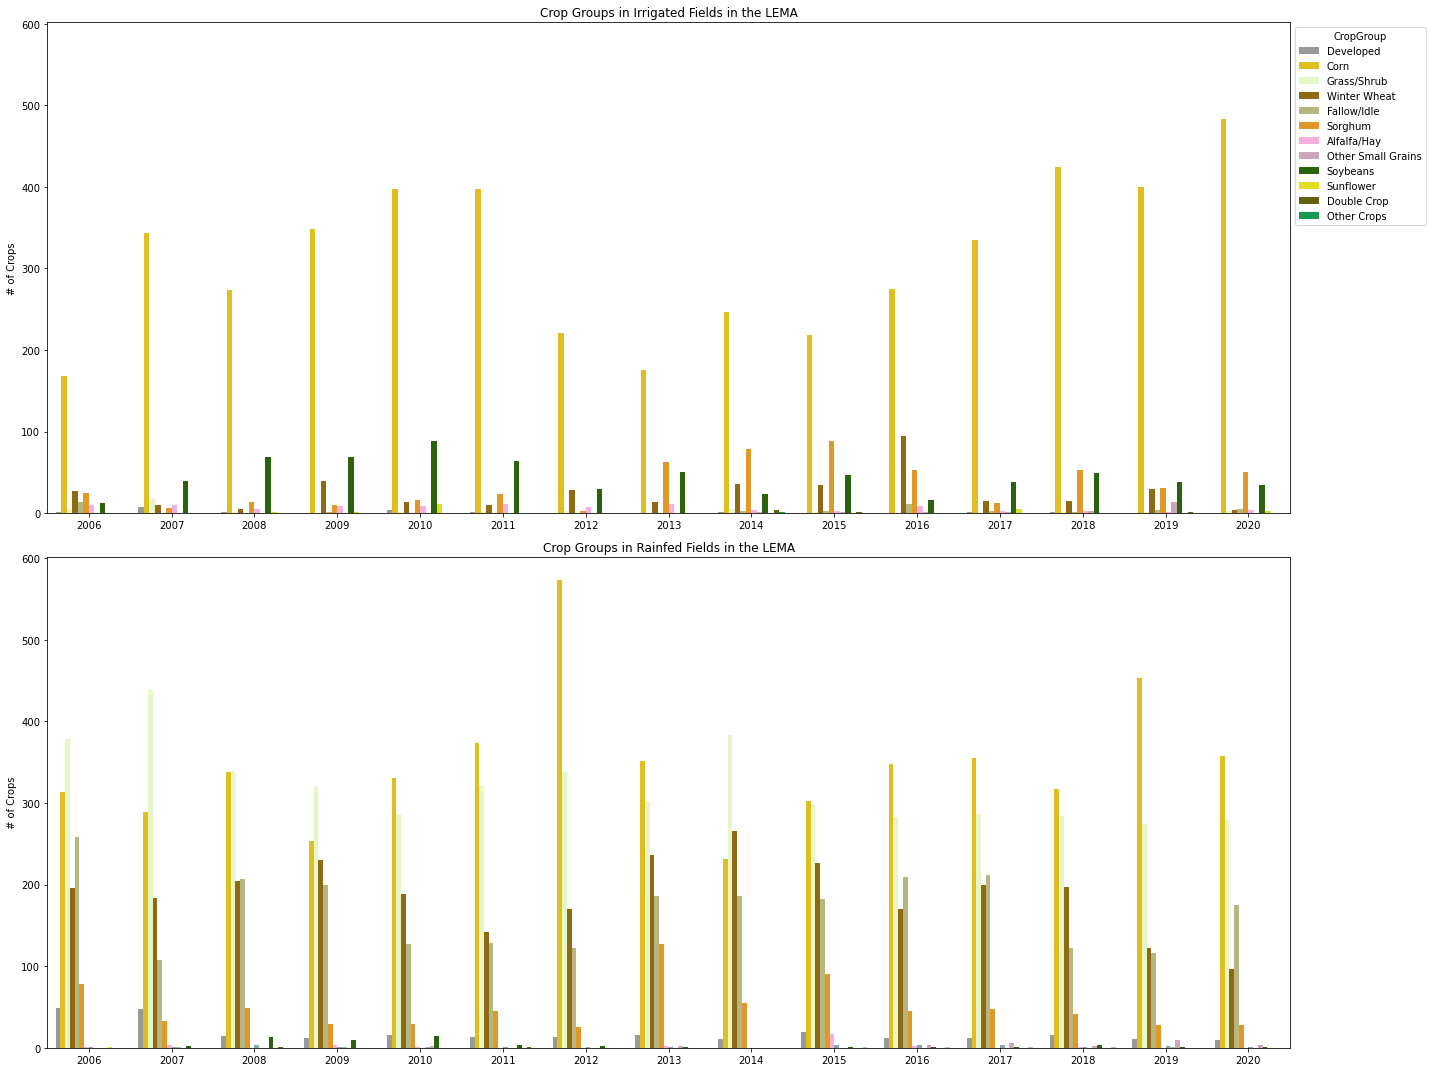

In [385]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, sharey=True, figsize = (20, 15))
fig.patch.set_facecolor('white')

sns.countplot(ax=axs[0], x='Year', hue='CropGroup', data=cdl_lema_fields_irr, palette=crop_color)
sns.countplot(ax=axs[1], x='Year', hue='CropGroup', data=cdl_lema_fields_rain, palette=crop_color)
sns.move_legend(axs[0], loc="upper left", bbox_to_anchor=(1, 1))
axs[1].legend_.remove()
axs[1].set(ylabel='# of Crops')
axs[0].set(ylabel='# of Crops')
axs[0].set(xlabel=None)
axs[1].set(xlabel=None)
axs[0].set_title('Crop Groups in Irrigated Fields in the LEMA')
axs[1].set_title('Crop Groups in Rainfed Fields in the LEMA')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('ChangeInCrops.png', dpi=500)
plt.show()

### Flowmeter Data

In [128]:
# Create filepath for shapefile
# Always run the filepath first for each different file you read in since the files are in different folders
wateruse_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Water\\WaterUse"

# Change working directory to the filepath
os.chdir(wateruse_fp)

# Read in file as a geodataframe using GeoPandas
flowmeter = gpd.read_file('WIMAS_WaterUse_1990to2020_SD6+10mi.gpkg')

In [129]:
flowmeter = flowmeter.drop(['OBJECTID_1', 'gmd', 'PDIV_ID_1'], axis=1)

In [130]:
pd.set_option('display.max_columns', None)
flowmeter.head()

PDIV_ID  long_nad83  lat_nad83 county_abrev source hpa_region hpa_aquifer  \
0      160  -100.61300   39.43699           SD      G        yes        None   
1      213  -100.60402   39.29712           SD      G        yes        None   
2      241  -100.44810   39.50374           SD      G        yes        None   
3      245  -100.91270   39.31441           TH      G        yes        None   
4      262  -100.79430   39.38393           TH      G        yes        None   

   OBJECTID  AF_USED_1990  AF_USED_1991  AF_USED_1992  AF_USED_1993  \
0     24227    172.097063    195.328540     62.390479     40.214699   
1     29217    103.381607    194.951067     89.550132     62.237035   
2     23470     92.272849     93.097766     30.639771     12.889327   
3     26449    207.186720    146.098677    124.510896     82.031358   
4     26630    270.675861    215.435889     49.715974     87.463288   

   AF_USED_1994  AF_USED_1995  AF_USED_1996  AF_USED_1997  AF_USED_1998  \
0    155.113840    103.093132    250.191038    114.021439    126.349160   
1    166.094319    162.107835    145.000000    165.000000    158.000000   
2     15.700427    109.187942     99.886144     46.674707    149.841492   
3    113.426075     74.573962     68.497565     65.827633     64.331550   
4    132.575932     87.279155    157.986319    110.387877    105.876612   

   AF_USED_1999  AF_USED_2000  AF_USED_2001  AF_USED_2002  AF_USED_2003  \
0    124.403178     19.562315    145.250437    209.939512    195.411400   
1    235.000000    218.000000    227.000000    236.000000    240.000000   
2    104.243964     75.000000     19.267088     33.608919    159.158695   
3    126.867802     39.358480     37.828333     40.450390     38.005100   
4    110.479943    175.663110    137.731663    176.813943    157.756152   

   AF_USED_2004  AF_USED_2005  AF_USED_2006  AF_USED_2007  AF_USED_2008  \
0     17.036007    166.662063    201.073497    169.463957    117.595465   
1    210.000000    111.000000    172.000000    196.000000     69.000000   
2    154.569358    122.092192     16.031837     16.040061     46.000000   
3     37.857794     31.888194     21.773755     35.169449     15.000000   
4    177.872709    167.929514    200.106797    174.696410    150.344789   

   AF_USED_2009  AF_USED_2010  AF_USED_2011  AF_USED_2012  AF_USED_2013  \
0      85.44304    174.597899    138.418173    208.881360    144.591853   
1      94.00000    138.000000    144.000000    132.000000    118.000000   
2      24.00000     48.000000    150.623598    203.631261    158.336172   
3       7.00000     13.000000     36.296344     58.000000     22.000000   
4      89.00000    146.000000    143.000000    233.000000    232.000000   

   AF_USED_2014  AF_USED_2015  AF_USED_2016  AF_USED_2017  AF_USED_2018  \
0      87.94449     90.208408    102.010121     30.752706       0.00000   
1     139.00000    108.000000     81.000000     70.000000      51.00000   
2     153.59781    154.803883    124.661272    132.836787     127.50613   
3      31.00000     28.000000     27.000000     19.000000      18.00000   
4     175.00000    187.000000    187.000000     86.000000     126.00000   

   AF_USED_2019  AF_USED_2020  ACRES_1990  ACRES_1991  ACRES_1992  ACRES_1993  \
0     65.070845    164.512615       124.0       124.0       123.0       124.0   
1      0.000000    163.000000       190.0       190.0       190.0       190.0   
2     80.318919    160.103851        70.0        68.0        65.0        80.0   
3      9.000000      6.000000       117.0        70.0       117.0       120.0   
4     83.000000    183.000000       140.0       150.0       110.0       120.0   

   ACRES_1994  ACRES_1995  ACRES_1996  ACRES_1997  ACRES_1998  ACRES_1999  \
0       124.0       124.0       123.0       123.0       123.0       123.0   
1       190.0       200.0       310.0       310.0       310.0       345.0   
2       100.0       100.0       100.0       100.0       100.0       120.0   
3       120.0        60.0       120.0        

In [233]:
flowmeter = flowmeter[['PDIV_ID',
                       'long_nad83',
                       'lat_nad83',
                       'OBJECTID',
                       'AF_USED_2016',
                       'AF_USED_2017',
                       'AF_USED_2018',
                       'AF_USED_2019',
                       'AF_USED_2020',
                       'ACRES_2016',
                       'ACRES_2017',
                       'ACRES_2018',
                       'ACRES_2019',
                       'ACRES_2020',
                       'AF_USED_IRR_2016',
                       'AF_USED_IRR_2017',
                       'AF_USED_IRR_2018',
                       'AF_USED_IRR_2019',
                       'AF_USED_IRR_2020',
                       'geometry']]

In [356]:
flowmeter

PDIV_ID  long_nad83  lat_nad83  OBJECTID  AF_USED_2016  AF_USED_2017  \
0         160 -100.613000  39.436990     24227    102.010121     30.752706   
1         213 -100.604020  39.297120     29217     81.000000     70.000000   
2         241 -100.448100  39.503740     23470    124.661272    132.836787   
3         245 -100.912700  39.314410     26449     27.000000     19.000000   
4         262 -100.794300  39.383930     26630    187.000000     86.000000   
...       ...         ...        ...       ...           ...           ...   
1118    87562 -100.479970  39.218190     29855      0.000000      0.000000   
1119    87817 -100.468215  39.225785     56175      0.000000      0.000000   
1120    88260 -100.637990  39.336730     32122      0.000000      0.000000   
1121    88416 -100.588579  39.442161     57848      0.000000      0.000000   
1122    88420 -100.370184  39.285371     56005      0.000000      0.000000   

      AF_USED_2018  AF_USED_2019  AF_USED_2020  ACRES_2016  ACRES_2017  \
0          0.00000     65.070845    164.512615       123.0       123.0   
1         51.00000      0.000000    163.000000       345.0       345.0   
2        127.50613     80.318919    160.103851       110.0       110.0   
3         18.00000      9.000000      6.000000        26.0        30.0   
4        126.00000     83.000000    183.000000       120.0       118.0   
...            ...           ...           ...         ...         ...   
1118       0.00000     29.000000     49.000000         0.0         0.0   
1119       0.00000      0.000000     49.000000         0.0         0.0   
1120       0.00000      0.000000    136.000000         0.0         0.0   
1121       0.00000      0.000000    151.000000         0.0         0.0   
1122       0.00000      0.000000      0.000000         0.0         0.0   

      ACRES_2018  ACRES_2019  ACRES_2020  AF_USED_IRR_2016  AF_USED_IRR_2017  \
0            0.0       123.0       123.0        102.010121         30.752706   
1          345.0         0.0       330.0         81.000000         70.000000   
2          110.0       110.0       180.0        124.661272        132.836787   
3           32.0        33.0        22.0         27.000000         19.000000   
4          118.0       120.0       117.0        187.000000         86.000000   
...          ...         ...         ...               ...               ...   
1118         0.0       120.0       120.0          0.000000          0.000000   
1119         0.0         0.0       120.0          0.000000          0.000000   
1120         0.0         0.0       123.0          0.000000          0.000000   
1121         0.0         0.0       120.0          0.000000          0.000000   
1122         0.0         0.0         0.0          0.000000          0.000000   

      AF_USED_IRR_2018  AF_USED_IRR_2019  AF_USED_IRR_2020  \
0              0.00000         65.070845        164.512615   
1             51.00000          0.000000        163.000000   
2            127.50613         80.318919        160.103851   
3             18.00000          9.000000          6.000000   
4            126.00000         83.000000        183.000000   
...                ...               ...               ...   
1118           0.00000         29.000000         49.000000   
1119           0.00000          0.000000         49.000000   
1120           0.00000          0.000000        136.000000   
1121           0.00000          0.000000        151.000000   
1122           0.00000          0.000000          0.000000   

                            geometry  
0     POINT (361187.133 4366513.038)  
1     POINT (361684.252 4350975.545)  
2     POINT (375497.905 4373680.540)  
3     POINT (335105.342 4353412.111)  
4     POINT (345466.600 4360918.737)  
...                              ...  
1118  POINT (372238.446 4342033.239)  
1119  POINT (373266.898 4342859.595)  
1120  POINT (358834.491 4355424.212)  
1121  POINT (363298.962 4367049.681)  
1122  POINT (381829.212 4349340.045)  

[1123

In [241]:
flowmeter_crs = flowmeter.to_crs(fields.crs)
lema_wells = gpd.clip(flowmeter_crs, lema)

In [286]:
flowmeter_m3 = gpd.GeoDataFrame(pd.concat([lema_wells['PDIV_ID'],
                                           lema_wells['AF_USED_IRR_2016'],
                                           lema_wells['AF_USED_IRR_2017'],
                                           lema_wells['AF_USED_IRR_2018'],
                                           lema_wells['AF_USED_IRR_2019'],
                                           lema_wells['AF_USED_IRR_2020']], 
                                           axis=1,
                                           keys=['PDIV_ID',
                                                 'AF_USED_IRR_2016',
                                                 'AF_USED_IRR_2017',
                                                 'AF_USED_IRR_2018',
                                                 'AF_USED_IRR_2019',
                                                 'AF_USED_IRR_2020']))

In [287]:
flowmeter_m3['2016'] = flowmeter_m3['AF_USED_IRR_2016'].multiply(1233.48)
flowmeter_m3['2017'] = flowmeter_m3['AF_USED_IRR_2017'].multiply(1233.48)
flowmeter_m3['2018'] = flowmeter_m3['AF_USED_IRR_2018'].multiply(1233.48)
flowmeter_m3['2019'] = flowmeter_m3['AF_USED_IRR_2019'].multiply(1233.48)
flowmeter_m3['2020'] = flowmeter_m3['AF_USED_IRR_2020'].multiply(1233.48)

In [288]:
flowmeter_m3 = pd.melt(flowmeter_m3, id_vars='PDIV_ID', value_vars=['2016', '2017', '2018', '2019', '2020']) # pivot longer
flowmeter_m3 = flowmeter_m3.rename(columns={"variable": "Year", "value": "MeasuredIrr_m3"}) # rename columns
flowmeter_m3.Year = flowmeter_m3.Year.astype('int64')

### Wrangling Irrigation Data

In [227]:
# Make a copy of estimated irrigation data for mean ensemble
irr_mean_ensemble_m = irr_mean_ensemble.copy()
# Divide each year column by 1000 to change from mm to m
irr_mean_ensemble_m['2016'] = irr_mean_ensemble_m['2016'].div(1000)
irr_mean_ensemble_m['2017'] = irr_mean_ensemble_m['2017'].div(1000)
irr_mean_ensemble_m['2018'] = irr_mean_ensemble_m['2018'].div(1000)
irr_mean_ensemble_m['2019'] = irr_mean_ensemble_m['2019'].div(1000)
irr_mean_ensemble_m['2020'] = irr_mean_ensemble_m['2020'].div(1000)
irr_mean_ensemble_m['2021'] = irr_mean_ensemble_m['2021'].div(1000)

In [301]:
# Create new df for estimated irrigation in m3
irr_mean_ensemble_m3 = gpd.GeoDataFrame(pd.concat([irr_mean_ensemble['UID'],
                                                   irr_mean_ensemble['geometry']],
                                                   axis=1,
                                                   keys=['UID', 'geometry']))

# multiply the area of each field by the estimated irrigation
irr_mean_ensemble_m3['2016'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2016']
irr_mean_ensemble_m3['2017'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2017']
irr_mean_ensemble_m3['2018'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2018']
irr_mean_ensemble_m3['2019'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2019']
irr_mean_ensemble_m3['2020'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2020']
irr_mean_ensemble_m3['2021'] = irr_mean_ensemble_m['area'] * irr_mean_ensemble_m['2021']

# Merge with LEMA fields
irr_mean_ensemble_m3 = irr_mean_ensemble.merge(lema, on='UID')

# Change the format of the df
irr_mean_ensemble_m3 = pd.melt(irr_mean_ensemble_m3, id_vars='UID', value_vars=['2016', '2017', '2018', '2019', '2020']) # pivot longer
irr_mean_ensemble_m3 = irr_mean_ensemble_m3.rename(columns={"variable": "Year", "value": "EstIrr_m3"}) # rename columns
irr_mean_ensemble_m3.Year = irr_mean_ensemble_m3.Year.astype('int64')


In [295]:
flowmeter_m3

PDIV_ID  Year  MeasuredIrr_m3
0      35096  2016       144317.16
1      18097  2016       125814.96
2      26685  2016       140616.72
3      35961  2016        69074.88
4      25246  2016       108546.24
..       ...   ...             ...
990     5391  2020            0.00
991    80684  2020       156651.96
992    32208  2020            0.00
993    25422  2020       173920.68
994    30601  2020       235594.68

[995 rows x 3 columns]

In [302]:
irr_mean_ensemble_m3

UID  Year  EstIrr_m3
0      347501.0  2016    197.603
1      347519.0  2016    262.703
2      347524.0  2016    154.626
3      347528.0  2016    221.474
4      347529.0  2016    368.819
...         ...   ...        ...
7685  1431965.0  2020    149.266
7686  1431966.0  2020    214.890
7687  1432138.0  2020    436.760
7688  1432391.0  2020    320.788
7689  1432393.0  2020    389.353

[7690 rows x 3 columns]

In [352]:
test = irr_mean_ensemble_m3.groupby('Year')['EstIrr_m3'].sum().reset_index()
test['EstIrr_km3'] = test['EstIrr_m3'].div(1000000)

In [353]:
test2 = flowmeter_m3.groupby('Year')['MeasuredIrr_m3'].sum().reset_index()
test2['MeasuredIrr_km3'] = test2['MeasuredIrr_m3'].div(1000000)

In [354]:
test2

Year  MeasuredIrr_m3  MeasuredIrr_km3
0  2016    2.064622e+07        20.646218
1  2017    1.577931e+07        15.779308
2  2018    1.762478e+07        17.624779
3  2019    1.179420e+07        11.794196
4  2020    2.501691e+07        25.016912

In [357]:
test

Year   EstIrr_m3  EstIrr_km3
0  2016  341199.901    0.341200
1  2017   29229.548    0.029230
2  2018  199754.810    0.199755
3  2019  -89121.326   -0.089121
4  2020  620177.693    0.620178